# PART 1: Simple Markowitz-Model implementation to estimate weightage of each stock in portfolio, where portfolio will have highest sharpe ratio


In [432]:
### PART 1: Simple Markowitz-Model implementation to estimate weightage of each stock in portfolio, where portfolio will have highest sharpe ratio

# Step 1: Import modules and define constants
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization
from scipy import interpolate
from scipy import stats
import plotly.express as px
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# On avge, 252 trading days a year
NUM_TRADING_DAYS = 252

# Generate random w (diff. portfolios)
NUM_PORTFOLIOS = 10000

# Our portfolio stocks
stocks = ['AAPL', 'NVDA', 'MAR', 'LMT', 'BA']

# Historical data - define START, END dates
start_date = '2010-01-01'
end_date = '2023-10-01'

In [433]:
# Step 2: Data retrieval and Visualisation
def download_data():
    # name of stock as key, stock values 2010-2023
    stock_data = {}
    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']
    return pd.DataFrame(stock_data)

def show_data(data):
    data.plot(figsize=(10, 5))
    plt.show()

In [434]:
# Step 3: Returns calculation and Portfolio Statistics
# To calculate return using normalisation, show statistics using annual metrics
def calculate_return(data):
    # Normalization - to measure variables in comparable metric
    log_return = np.log(data / data.shift(1))
    return log_return[1:]                    # Don't need first row of dataset, since values are NaN

def show_statistics(returns):
    # Instead of daily metrics, use annual metrics
    annual_mean = returns.mean() * NUM_TRADING_DAYS
    annual_covariance = returns.cov() * NUM_TRADING_DAYS
    print("Annual Mean Returns:")
    print(annual_mean)
    print("Annual Covariance Matrix:")
    print(annual_covariance)

In [435]:
# Step 4: To visaulise efficient frontier and displau portfolio metrics
def show_mean_variance(returns, weights):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    print("Expected portfolio mean (return): ", portfolio_return)
    print("Expected portfolio volatility (standard deviation): ", portfolio_volatility)


# Generate multiple portfolios: Display their efficient frontier
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, returns, c=returns/volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

In [436]:
# Step 5: Portfolio Generation
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        # Generate random weight
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_mean = np.sum(returns.mean() * w) * NUM_TRADING_DAYS
        portfolio_risk = np.sqrt(np.dot(w.T, np.dot(returns.cov() * NUM_TRADING_DAYS, w)))
        portfolio_means.append(portfolio_mean)
        portfolio_risks.append(portfolio_risk)

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)


In [437]:
# Step 6: Portfolio Optimization Functions
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])

# Scipy optimize module can find the minimum of a given function
# Maximum of f(x) is minimum of -f(x)
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

# Constraints: Sum of weights = 1
# f(x) = 0 this is the function to minimize
def optimize_portfolio(weights, returns):
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # Weights can be 1 at most: 1 when 100% of money invested in single stock
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns, method='SLSQP', bounds=bounds, constraints=constraints)


In [438]:
# Step 7: Portfolio Results Presentation
def print_optimal_portfolio(optimum, returns):
    print("Optimal portfolio weights:", optimum['x'].round(3))
    expected_return, volatility, sharpe_ratio = statistics(optimum['x'].round(3), returns)
    print(f"Expected return: {expected_return}")
    print(f"Expected volatility (standard deviation): {volatility}")
    print(f"Sharpe ratio: {sharpe_ratio}")

def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()

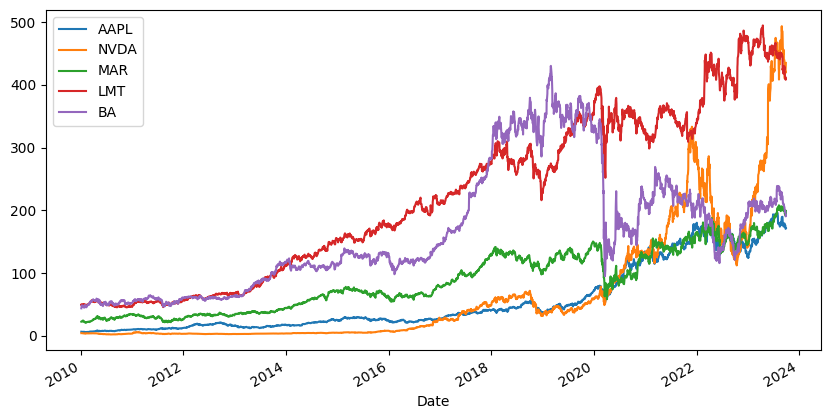



Annual Mean Returns:
AAPL    0.238519
NVDA    0.337451
MAR     0.157839
LMT     0.153483
BA      0.107614
dtype: float64
Annual Covariance Matrix:
          AAPL      NVDA       MAR       LMT        BA
AAPL  0.080628  0.064419  0.036103  0.021053  0.041491
NVDA  0.064419  0.200282  0.054602  0.025807  0.060011
MAR   0.036103  0.054602  0.098672  0.022343  0.065004
LMT   0.021053  0.025807  0.022343  0.044809  0.036176
BA    0.041491  0.060011  0.065004  0.036176  0.130475




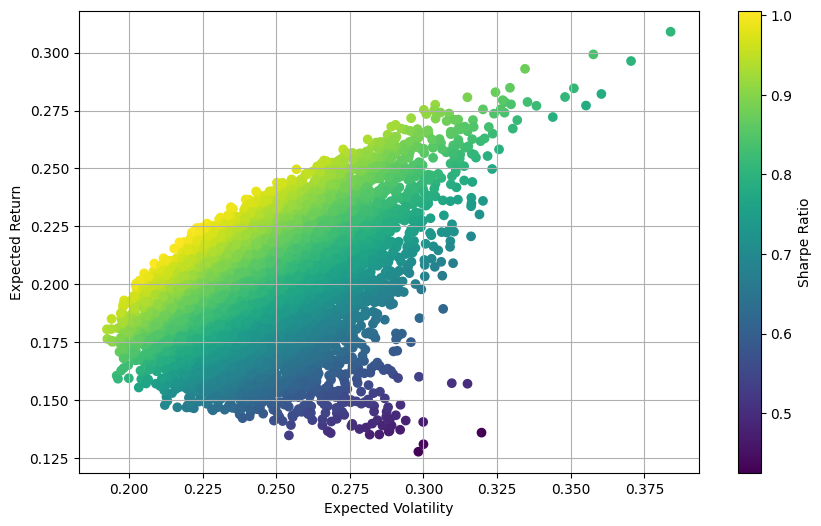



Optimal portfolio weights: [0.364 0.182 0.004 0.45  0.   ]
Expected return: 0.21793547769383292
Expected volatility (standard deviation): 0.21521350295859723
Sharpe ratio: 1.0126477878841986


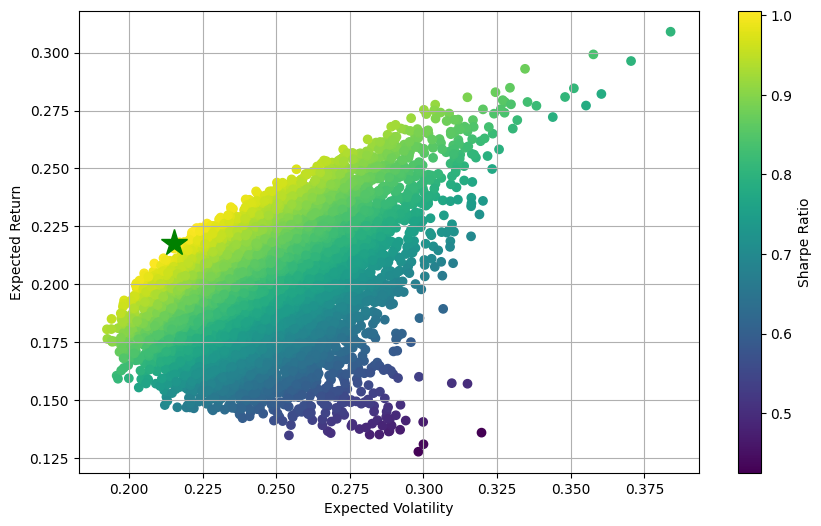

In [439]:
# Main Workflow
# First output: Display stock prices of the 5 stocks, using yfinance
dataset = download_data()
show_data(dataset)
print('\n')

# Second output: Annual Mean returns and covariance matrix of stocks in portfolio
log_daily_returns = calculate_return(dataset)
show_statistics(log_daily_returns)
print('\n')

# Third output: Display Scatterplot of expected return against expected volatility, color coded by sharpe ratio
weights, means, risks = generate_portfolios(log_daily_returns)
show_portfolios(means, risks)
print('\n')

# Fourth output: Display most optimal portfolio (highest sharpe ratio), denoted by green star
# Each value in the list for optimal portfolio shows the corresponding optimal percentage each stock should take in portfolio
optimum = optimize_portfolio(weights, log_daily_returns)
print_optimal_portfolio(optimum, log_daily_returns)
show_optimal_portfolio(optimum, log_daily_returns, means, risks)

# Part 2: Incorporating sentiment score of earnings call and technical indicators with stock data

In [440]:
### PART 2: Analysing of the 5 stock prices, with incorporation of their corresponding sentiment score (extracted using NLP and FinBert)
### NOTE: Wil not be forecasting prices because there are measured in absolute terms and thus harder to compare across time and other assets.
###       Hence, will be forecasting daily returns instead

# Step 1: Import modules and load data
import yfinance as yf
import math
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

In [441]:
stocks = ['AAPL', 'NVDA', 'MAR', 'LMT', 'BA']
# stocks = []
stock_data = yf.download(stocks, start='2010-01-01', end='2023-10-20', group_by='tickers')
stock_data.head()

[*********************100%%**********************]  5 of 5 completed


LMT                                                       \
                 Open       High        Low      Close  Adj Close   Volume   
Date                                                                         
2010-01-04  75.870003  76.949997  75.519997  76.849998  49.773979  2408300   
2010-01-05  76.620003  77.790001  76.550003  77.650002  50.292110  2356500   
2010-01-06  76.099998  77.190002  75.849998  76.510002  49.553768  5208100   
2010-01-07  76.169998  76.199997  73.610001  74.410004  48.193661  7038300   
2010-01-08  74.349998  75.940002  74.320000  75.610001  48.970852  3629400   

                  MAR                                   ...      AAPL  \
                 Open       High        Low      Close  ...       Low   
Date                                                    ...             
2010-01-04  26.022619  26.324223  25.636192  26.041470  ...  7.585000   
2010-01-05  25.984921  26.314796  25.796417  26.192270  ...  7.616071   
2010-01-06  26.145145  26.409048  25.947220  26.267672  ...  7.526786   
2010-01-07  26.154572  26.550425  26.107447  26.371347  ...  7.466071   
2010-01-08  26.182846  26.550425  26.163996  26.427898  ...  7.466429   

                                                  BA                        \
               Close Adj Close     Volume       Open       High        Low   
Date                                                                         
2010-01-04  7.643214  6.487533  493729600  55.720001  56.389999  54.799999   
2010-01-05  7.656429  6.498752  601904800  56.250000  58.279999  56.000000   
2010-01-06  7.534643  6.395379  552160000  58.230000  59.990002  57.880001   
2010-01-07  7.520714  6.383557  477131200  59.509998  62.310001  59.020000   
2010-01-08  7.570714  6.425997  447610800  61.540001  61.779999  60.860001   

                                            
                Close  Adj Close    Volume  
Date                                        
2010-01-04  56.180000  43.777550   6186700  
2010-01-05  58.020000  45.211349   8867800  
2010-01-06  59.779999  46.582802   8836500  
2010-01-07  62.200001  48.468555  14379100  
2010-01-08  61.599998  48.001019   7146600  

[5 rows x 30 columns]

In [442]:
# Step 2: Clean and explore data
stock_data.describe()

LMT                                                      \
              Open         High          Low        Close    Adj Close   
count  3473.000000  3473.000000  3473.000000  3473.000000  3473.000000   
mean    250.547558   252.693110   248.401342   250.563409   220.310309   
std     129.657013   130.908460   128.383067   129.615066   132.109985   
min      66.989998    68.400002    66.360001    66.870003    45.362408   
25%     106.910004   107.709999   106.260002   107.050003    80.153671   
50%     255.100006   257.000000   252.770004   254.970001   212.356476   
75%     362.299988   365.579987   359.450012   361.989990   334.732727   
max     502.000000   508.100006   498.000000   501.410004   494.749481   

                             MAR                                         ...  \
             Volume         Open         High          Low        Close  ...   
count  3.473000e+03  3473.000000  3473.000000  3473.000000  3473.000000  ...   
mean   1.662178e+06    91.785428    92.861702    90.708125    91.821133  ...   
std    1.072282e+06    48.546887    49.150517    47.958425    48.564686  ...   
min    3.209000e+05    24.175306    24.693686    24.024506    24.260132  ...   
25%    1.038300e+06    41.419998    41.689999    40.970001    41.389999  ...   
50%    1.365100e+06    81.209999    81.989998    80.059998    81.000000  ...   
75%    1.935600e+06   134.919998   136.449997   133.490005   135.050003  ...   
max    1.396230e+07   208.389999   210.979996   207.600006   208.509995  ...   

              AAPL                                                   BA  \
               Low        Close    Adj Close        Volume         Open   
count  3473.000000  3473.000000  3473.000000  3.473000e+03  3473.000000   
mean     57.488376    58.135312    56.176044  2.449506e+08   173.790193   
std      53.084844    53.719198    54.152632  2.208448e+08    94.181145   
min       6.794643     6.858929     5.821836  3.145820e+07    55.720001   
25%      19.245001    19.445356    16.960625  9.453760e+07   100.250000   
50%      31.719999    31.950001    28.829893  1.550880e+08   145.960007   
75%      79.125000    79.750000    78.009254  3.325616e+08   218.889999   
max     195.279999   196.449997   196.185074  1.880998e+09   446.010010   

                                                                         
              High          Low        Close    Adj Close        Volume  
count  3473.000000  3473.000000  3473.000000  3473.000000  3.473000e+03  
mean    175.828304   171.682289   173.751471   164.182916  7.310036e+06  
std      95.270987    93.042401    94.168854    96.619566  8.694362e+06  
min      56.389999    54.799999    56.180000    43.777550  7.889000e+05  
25%     102.419998    99.300003   100.750000    86.017097  3.443600e+06  
50%     147.270004   143.979996   145.860001   132.949997  4.725000e+06  
75%     222.300003   215.910004   218.110001   218.110001  7.371100e+06  
max     446.010010   440.190002   440.619995   430.299988  1.032128e+08  

[8 rows x 30 columns]

In [443]:
# Check for presence of missing values
missing_values_count = stock_data.isnull().sum()
missing_values_count

LMT   Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
MAR   Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
NVDA  Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
AAPL  Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
BA    Open         0
      High         0
      Low          0
      Close        0
      Adj Close    0
      Volume       0
dtype: int64

In [444]:
# Check shape of dataframe
stock_data.shape

(3473, 30)

In [445]:
# Check columns of dataframe
stock_data.columns

MultiIndex([( 'LMT',      'Open'),
            ( 'LMT',      'High'),
            ( 'LMT',       'Low'),
            ( 'LMT',     'Close'),
            ( 'LMT', 'Adj Close'),
            ( 'LMT',    'Volume'),
            ( 'MAR',      'Open'),
            ( 'MAR',      'High'),
            ( 'MAR',       'Low'),
            ( 'MAR',     'Close'),
            ( 'MAR', 'Adj Close'),
            ( 'MAR',    'Volume'),
            ('NVDA',      'Open'),
            ('NVDA',      'High'),
            ('NVDA',       'Low'),
            ('NVDA',     'Close'),
            ('NVDA', 'Adj Close'),
            ('NVDA',    'Volume'),
            ('AAPL',      'Open'),
            ('AAPL',      'High'),
            ('AAPL',       'Low'),
            ('AAPL',     'Close'),
            ('AAPL', 'Adj Close'),
            ('AAPL',    'Volume'),
            (  'BA',      'Open'),
            (  'BA',      'High'),
            (  'BA',       'Low'),
            (  'BA',     'Close'),
            (  'BA',

In [446]:
aapl = yf.Ticker('AAPL')

# uncomment later
# aapl.info

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Line charts for AAPL: 



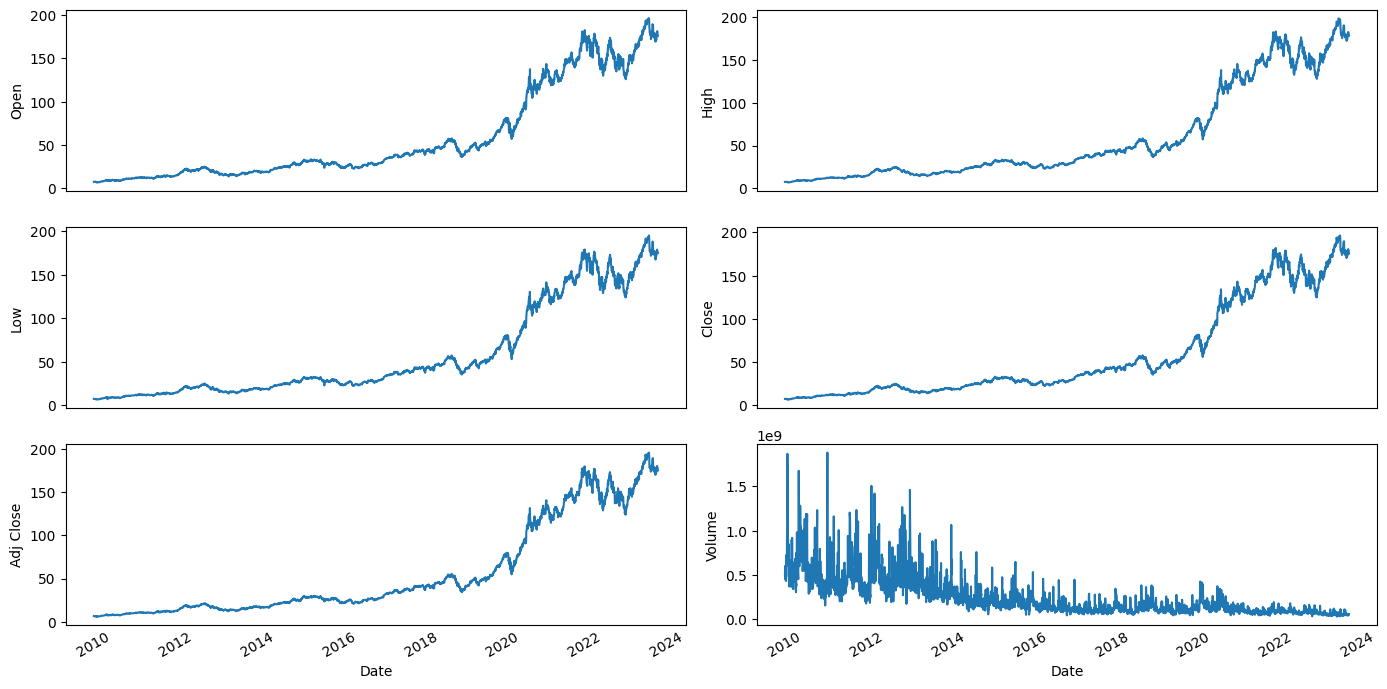

Line charts for NVDA: 



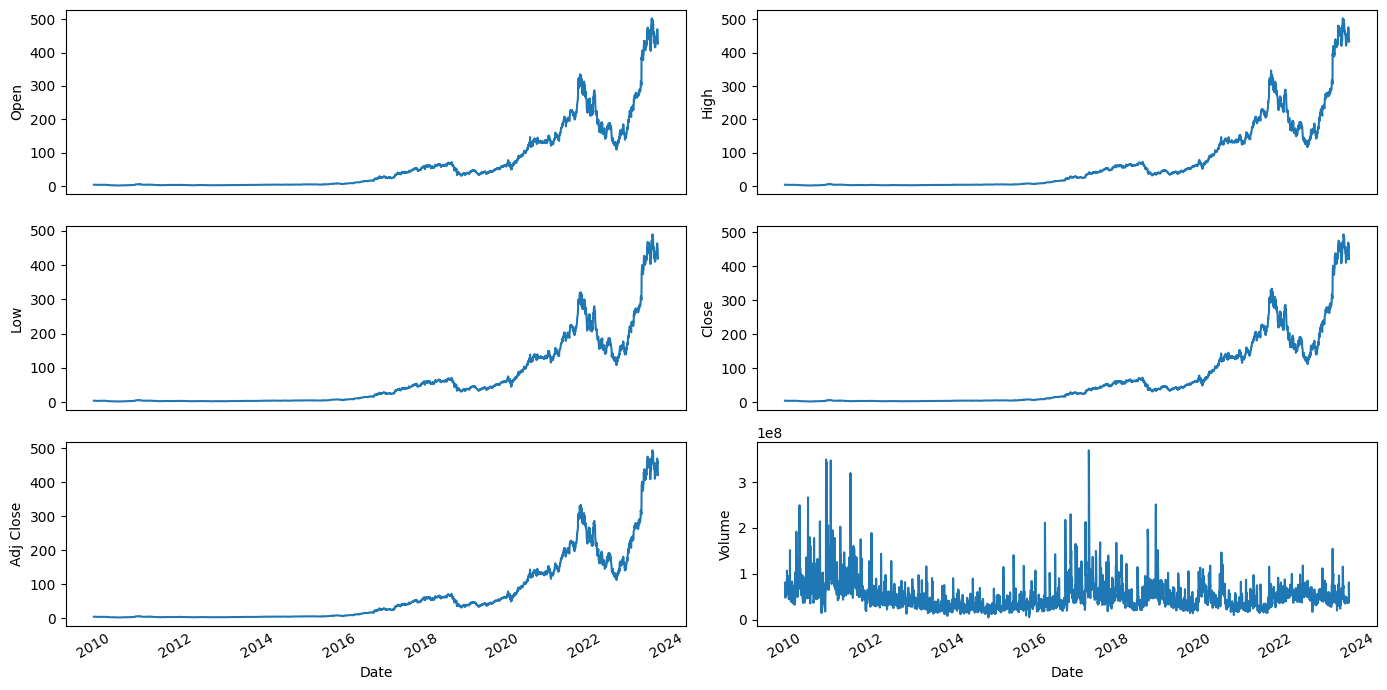

Line charts for MAR: 



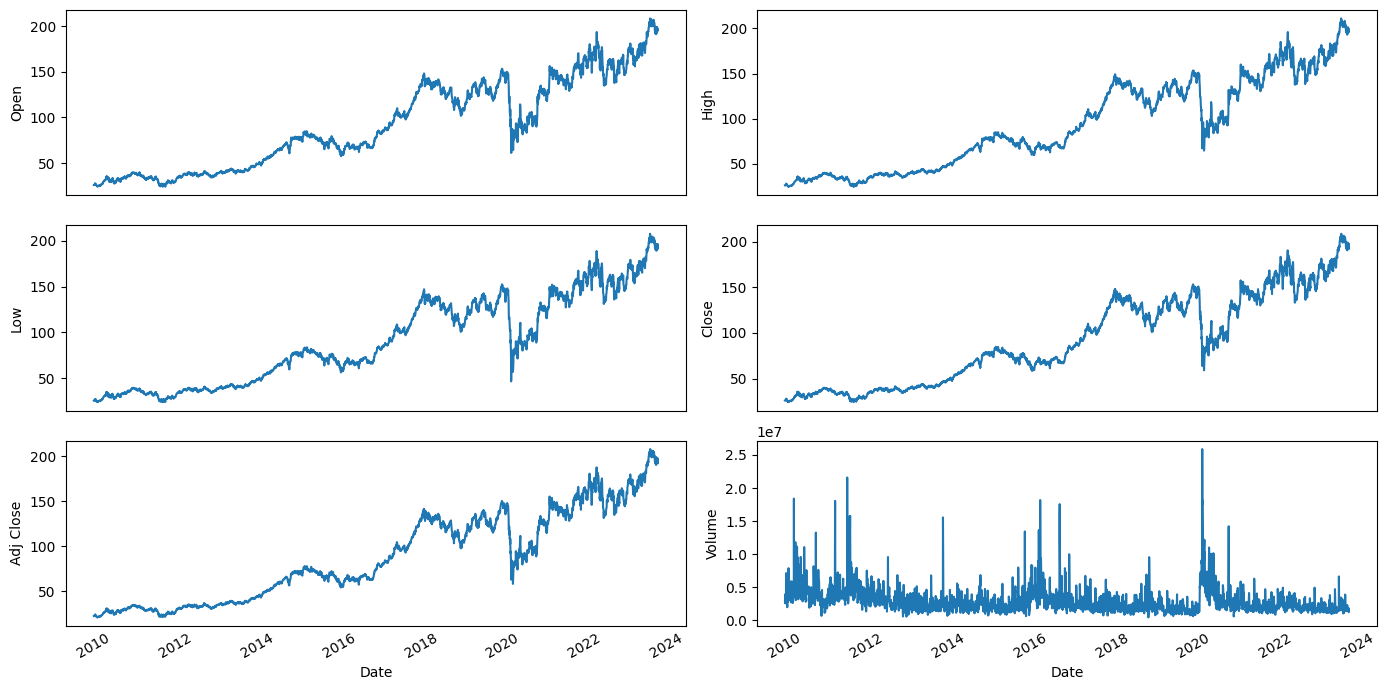

Line charts for LMT: 



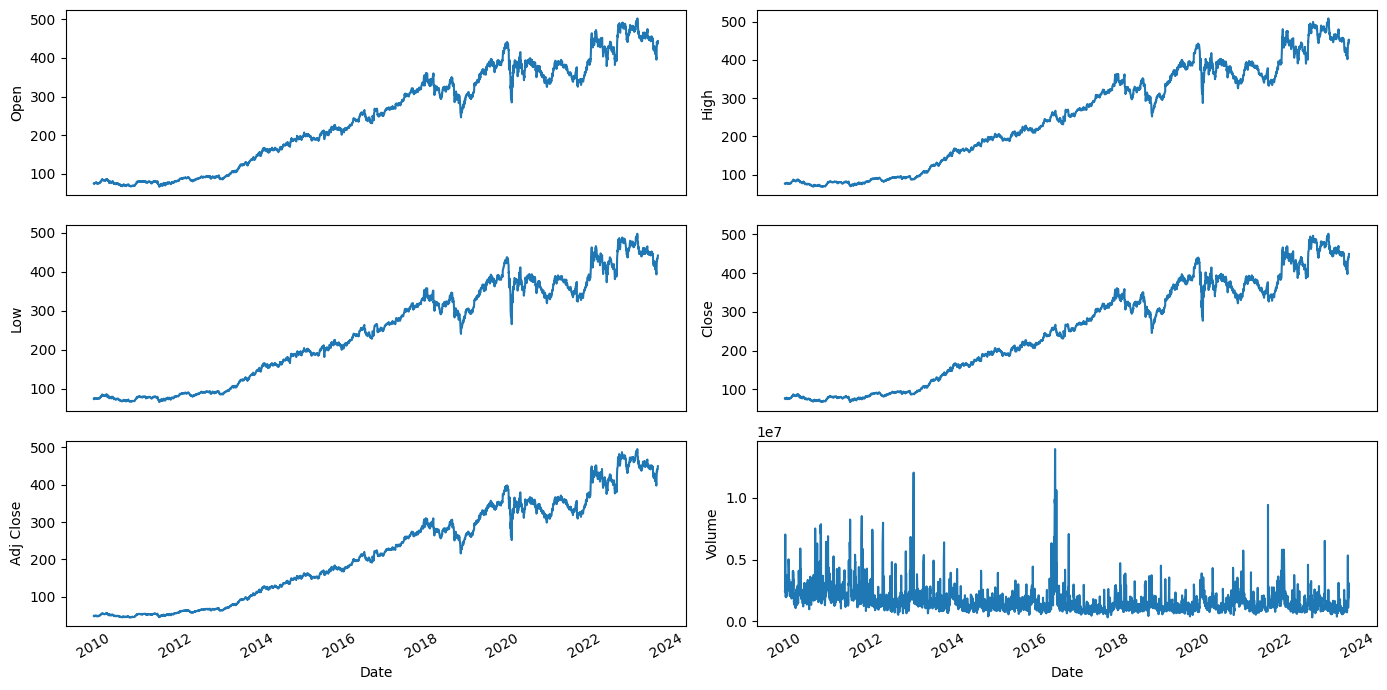

Line charts for BA: 



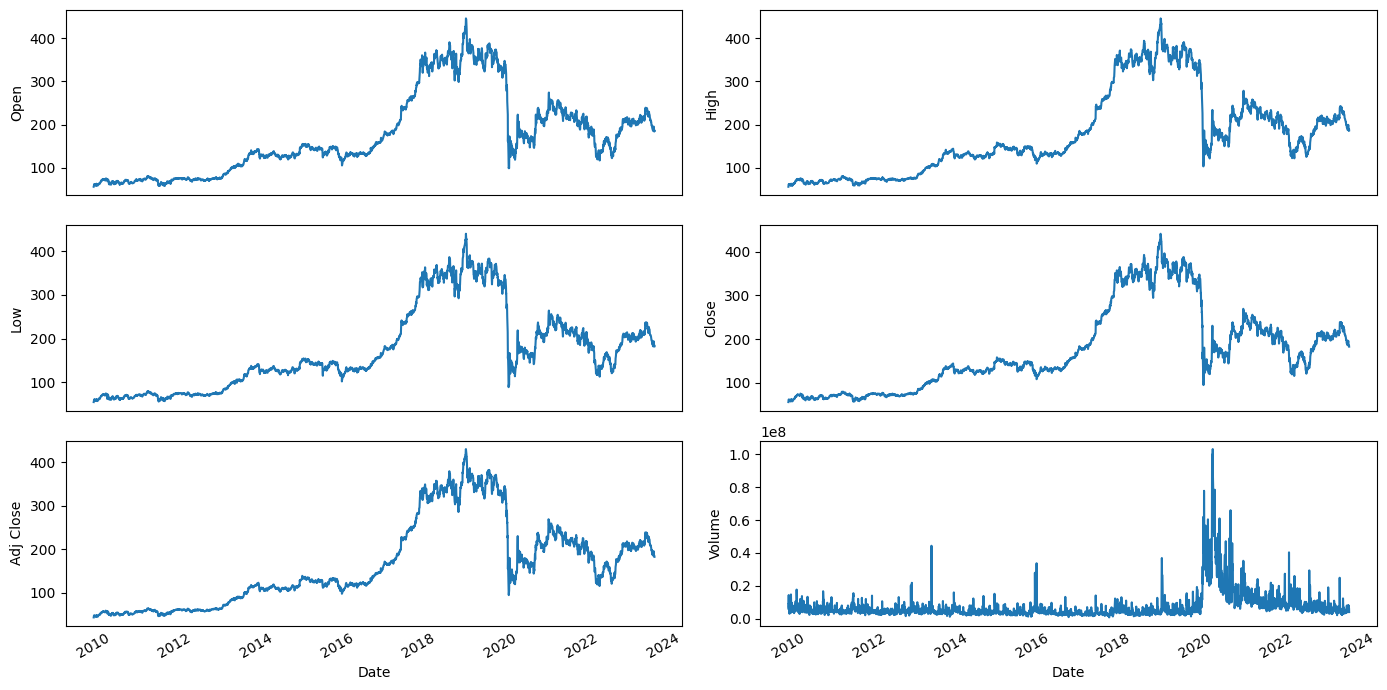

In [447]:
# Explore data: Create line charts for columns of dataset
# Define the DataFrame to plot (Will display line charts for 5 stocks separately here for ease of visualisation)
aapl_df = yf.download('AAPL', start='2010-01-01', end='2023-10-20')
nvda_df = yf.download('NVDA', start='2010-01-01', end='2023-10-20')
mar_df = yf.download('MAR', start='2010-01-01', end='2023-10-20')
lmt_df = yf.download('LMT', start='2010-01-01', end='2023-10-20')
ba_df = yf.download('BA', start='2010-01-01', end='2023-10-20')

# Function to plot line chart of every stock in stock_df (For a quick glance)
def plot_line_charts(stock_df):
    # Plot line charts
    df_plot = stock_df.copy()

    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()

print("Line charts for AAPL: \n")
plot_line_charts(aapl_df)
print("Line charts for NVDA: \n")
plot_line_charts(nvda_df)
print("Line charts for MAR: \n")
plot_line_charts(mar_df)
print("Line charts for LMT: \n")
plot_line_charts(lmt_df)
print("Line charts for BA: \n")
plot_line_charts(ba_df)

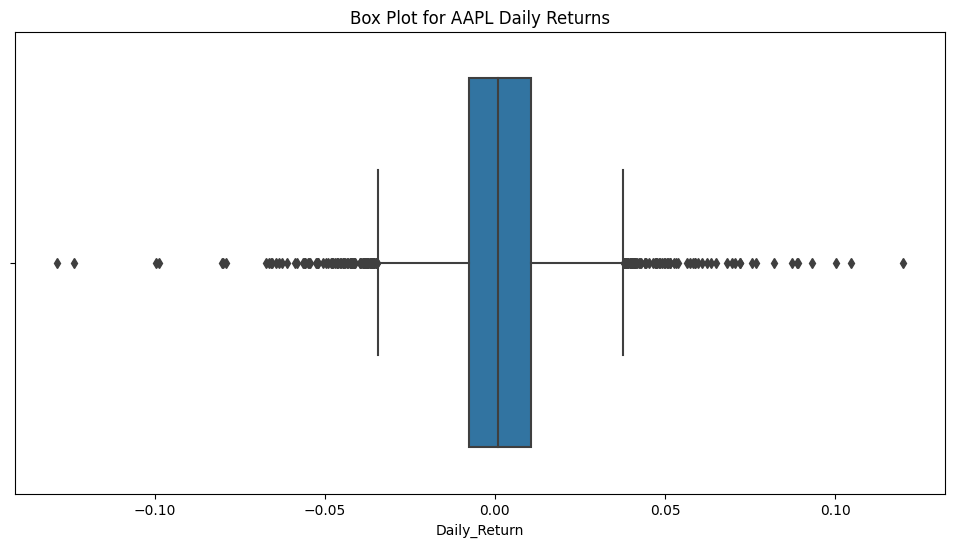

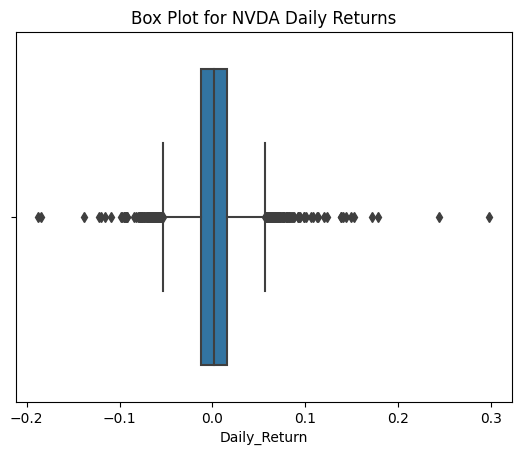

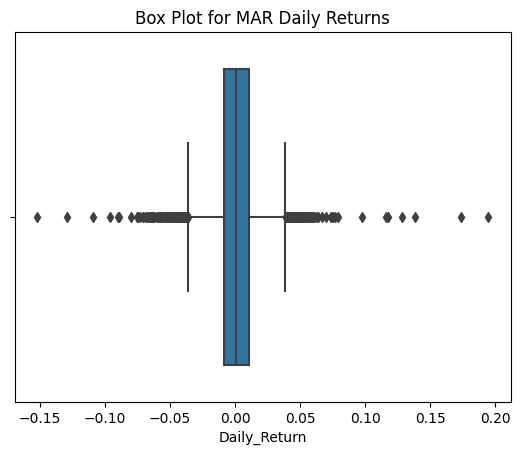

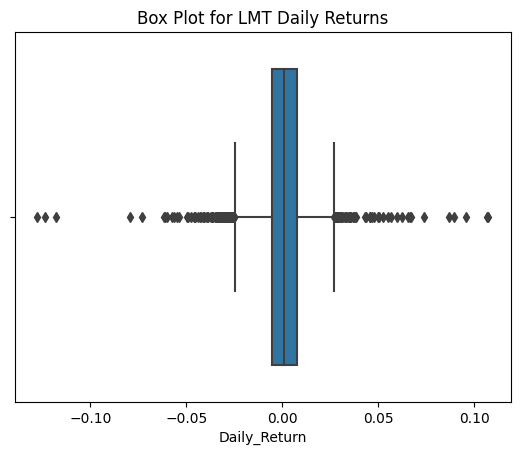

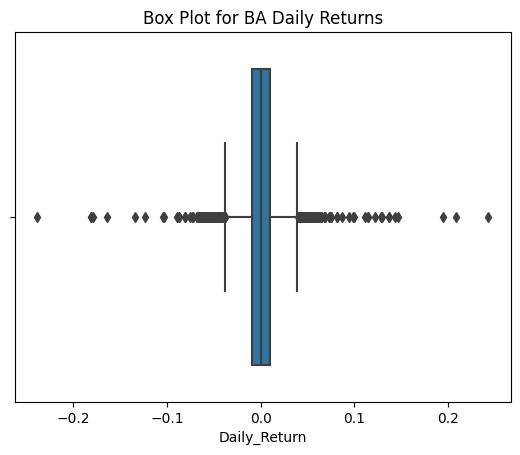

In [448]:
# Step 3: Feature Engineering
# Forecast daily returns by creating return column and analyse possible outliers using boxplot

for stock in stocks:
    stock_data[stock, 'Daily_Return'] = stock_data[stock]['Adj Close'].pct_change()
    stock_data = stock_data.sort_index(axis=1)
# print(stock_data)

# Perform data analysis to identify possible outliers
plt.figure(figsize=(12, 6))
for stock in stocks:
    sns.boxplot(x=stock_data[stock]["Daily_Return"])
    plt.title(f'Box Plot for {stock} Daily Returns')
    plt.show()
    print("\n")

In [449]:
# Since we feel that outliers are meaningful and representative of actual market conditions/events, we decide not to remove them
# Using log transformation to reduce the impact of outliers, instead of removing them
# Will be log tansforming the outliers to certain features in dataframe merged

stock_data.head()

AAPL                                                       \
           Adj Close     Close Daily_Return      High       Low      Open   
Date                                                                        
2010-01-04  6.487533  7.643214          NaN  7.660714  7.585000  7.622500   
2010-01-05  6.498752  7.656429     0.001729  7.699643  7.616071  7.664286   
2010-01-06  6.395379  7.534643    -0.015907  7.686786  7.526786  7.656429   
2010-01-07  6.383557  7.520714    -0.001848  7.571429  7.466071  7.562500   
2010-01-08  6.425997  7.570714     0.006648  7.571429  7.466429  7.510714   

                              BA                          ...        MAR  \
               Volume  Adj Close      Close Daily_Return  ...        Low   
Date                                                      ...              
2010-01-04  493729600  43.777550  56.180000          NaN  ...  25.636192   
2010-01-05  601904800  45.211349  58.020000     0.032752  ...  25.796417   
2010-01-06  552160000  46.582802  59.779999     0.030334  ...  25.947220   
2010-01-07  477131200  48.468555  62.200001     0.040482  ...  26.107447   
2010-01-08  447610800  48.001019  61.599998    -0.009646  ...  26.163996   

                                    NVDA                                      \
                 Open   Volume Adj Close   Close Daily_Return   High     Low   
Date                                                                           
2010-01-04  26.022619  2860350  4.240801  4.6225          NaN  4.655  4.5275   
2010-01-05  25.984921  2627885  4.302728  4.6900     0.014603  4.740  4.6050   
2010-01-06  26.145145  2789900  4.330251  4.7200     0.006397  4.730  4.6425   
2010-01-07  26.154572  2560724  4.245387  4.6275    -0.019598  4.715  4.5925   
2010-01-08  26.182846  3961031  4.254563  4.6375     0.002161  4.670  4.5625   

                              
              Open    Volume  
Date                          
2010-01-04  4.6275  80020400  
2010-01-05  4.6050  72864800  
2010-01-06  4.6875  64916800  
2010-01-07  4.6950  54779200  
2010-01-08  4.5900  47816800  

[5 rows x 35 columns]

#Import Sentiment score from Excel

In [450]:
# Adding text sentiment score as an additional column to dataframe

# Import excel data of sentiment score as dataframe
df_sentiment_score = pd.read_excel("sentiment_score.xlsx")
df_sentiment_score

,filename,sentiment_score
0,2016-Jan-28-BA.N-138020839119-Transcript.txt,0.290381
1,2015-Apr-22-BA.N-140063175207-Transcript.txt,0.187387
2,2022-Oct-26-BA.N-140697322944-Transcript.txt,0.086556
3,2010-Jul-28-BA.N-137028827968-Transcript.txt,0.052885
4,2014-Jan-29-BA.N-139067099110-Transcript.txt,0.257669
...,...,...
269,2017-May-03-AAPL.OQ-137410537849-Transcript.txt,0.266504
270,2015-Oct-28-AAPL.OQ-139180636945-Transcript.txt,0.286697
271,2012-Jul-25-AAPL.OQ-138648438585-Transcript.txt,0.175141
272,2011-Apr-21-AAPL.OQ-140555924186-Transcript.txt,0.204651


In [451]:
# Convert filename column, data will be in the format of YYYY-MM-DD.TickerName
def convert_column(filename):
    file_name_splitted = filename.split('.')
    final_file_name = ""
    month_to_numeric = {"Jan": "01",
                        "Feb": "02",
                        "Mar": "03",
                        "Apr": "04",
                        "May": "05",
                        "Jun": "06",
                        "Jul": "07",
                        "Aug": "08",
                        "Sep": "09",
                        "Oct": "10",
                        "Nov": "11",
                        "Dec": "12"
                        }

    splitted_by_dash = file_name_splitted[0].split('-')
    month_alphabet = splitted_by_dash[1]
    month_numeric = month_to_numeric[month_alphabet]
    final_file_name += splitted_by_dash[0] + "-" + month_numeric + "-" + splitted_by_dash[2] + "." + splitted_by_dash[3]

    return final_file_name

df_sentiment_score['filename'] = df_sentiment_score['filename'].apply(convert_column)
df_sentiment_score

,filename,sentiment_score
0,2016-01-28.BA,0.290381
1,2015-04-22.BA,0.187387
2,2022-10-26.BA,0.086556
3,2010-07-28.BA,0.052885
4,2014-01-29.BA,0.257669
...,...,...
269,2017-05-03.AAPL,0.266504
270,2015-10-28.AAPL,0.286697
271,2012-07-25.AAPL,0.175141
272,2011-04-21.AAPL,0.204651


In [452]:
# Function to make the date as row index, while column will be stock ticker
def format_filename(row):
    parts = row['filename'].split('.')
    return pd.Series([parts[0], parts[1], row['sentiment_score']], index=['Date', 'Ticker', 'Sentiment_score'])

# Apply the function to each row and restructure the DataFrame
df_sentiment_score = df_sentiment_score.apply(format_filename, axis=1)

# Set the 'Date' column as the row index
df_sentiment_score.set_index('Date', inplace=True)
# df_sentiment_score.groupby("Ticker")


In [453]:
df_sentiment_score = df_sentiment_score.groupby("Ticker")

sentiment_score_dict = {}
for stock in stocks:
    suffixed_df = df_sentiment_score.get_group(f"{stock}").add_prefix(f'{stock}_')
    suffixed_df.drop([f"{stock}_Ticker"], axis=1, inplace=True)
    new_df = suffixed_df.reset_index('Date')
    sentiment_score_dict[f'{stock}_df_sentiment_score'] = new_df


# print(sentiment_score_dict)


In [454]:
sentiment_score_dict

{'AAPL_df_sentiment_score':           Date  AAPL_Sentiment_score
 0   2019-01-30              0.219626
 1   2023-08-04              0.300216
 2   2011-01-19              0.287645
 3   2022-04-29              0.177384
 4   2011-07-20              0.257669
 5   2021-10-29              0.228690
 6   2013-01-24              0.169261
 7   2013-07-24              0.160088
 8   2021-04-29              0.266525
 9   2018-08-01              0.340686
 10  2012-04-25              0.170018
 11  2017-02-01              0.325980
 12  2018-11-02              0.314861
 13  2014-10-21              0.230620
 14  2019-07-31              0.364269
 15  2014-07-23              0.242152
 16  2011-10-19              0.238876
 17  2016-01-27              0.204167
 18  2015-01-28              0.230189
 19  2015-07-22              0.303419
 20  2012-10-26              0.194981
 21  2016-10-26              0.216110
 22  2020-07-31              0.263789
 23  2015-04-28              0.268482
 24  2020-01-29        

In [455]:
stock_data

AAPL                                                   \
             Adj Close       Close Daily_Return        High         Low   
Date                                                                      
2010-01-04    6.487533    7.643214          NaN    7.660714    7.585000   
2010-01-05    6.498752    7.656429     0.001729    7.699643    7.616071   
2010-01-06    6.395379    7.534643    -0.015907    7.686786    7.526786   
2010-01-07    6.383557    7.520714    -0.001848    7.571429    7.466071   
2010-01-08    6.425997    7.570714     0.006648    7.571429    7.466429   
...                ...         ...          ...         ...         ...   
2023-10-13  178.850006  178.850006    -0.010293  181.929993  178.139999   
2023-10-16  178.720001  178.720001    -0.000727  179.080002  176.509995   
2023-10-17  177.149994  177.149994    -0.008785  178.419998  174.800003   
2023-10-18  175.839996  175.839996    -0.007395  177.580002  175.110001   
2023-10-19  175.460007  175.460007    -0.002161  177.839996  175.190002   

                                           BA                           ...  \
                  Open     Volume   Adj Close       Close Daily_Return  ...   
Date                                                                    ...   
2010-01-04    7.622500  493729600   43.777550   56.180000          NaN  ...   
2010-01-05    7.664286  601904800   45.211349   58.020000     0.032752  ...   
2010-01-06    7.656429  552160000   46.582802   59.779999     0.030334  ...   
2010-01-07    7.562500  477131200   48.468555   62.200001     0.040482  ...   
2010-01-08    7.510714  447610800   48.001019   61.599998    -0.009646  ...   
...                ...        ...         ...         ...          ...  ...   
2023-10-13  181.419998   51427100  184.910004  184.910004    -0.033403  ...   
2023-10-16  176.750000   52517000  184.929993  184.929993     0.000108  ...   
2023-10-17  176.649994   57549400  185.600006  185.600006     0.003623  ...   
2023-10-18  175.580002   54764400  185.690002  185.690002     0.000485  ...   
2023-10-19  176.039993   59302900  182.789993  182.789993    -0.015617  ...   

                   MAR                             NVDA              \
                   Low        Open   Volume   Adj Close       Close   
Date                                                                  
2010-01-04   25.636192   26.022619  2860350    4.240801    4.622500   
2010-01-05   25.796417   25.984921  2627885    4.302728    4.690000   
2010-01-06   25.947220   26.145145  2789900    4.330251    4.720000   
2010-01-07   26.107447   26.154572  2560724    4.245387    4.627500   
2010-01-08   26.163996   26.182846  3961031    4.254563    4.637500   
...                ...         ...      ...         ...         ...   
2023-10-13  192.479996  197.699997  1531100  454.609985  454.609985   
2023-10-16  195.059998  196.309998  1382600  460.950012  460.950012   
2023-10-17  196.350006  196.679993  1230900  439.380005  439.380005   
2023-10-18  193.949997  195.869995  1255800  421.959991  421.959991   
2023-10-19  191.470001  195.199997  1770700  421.010010  421.010010   

                                                                       
           Daily_Return        High         Low        Open    Volume  
Date                                                                   
2010-01-04          NaN    4.655000    4.527500    4.627500  80020400  
2010-01-05     0.014603    4.740000    4.605000    4.605000  72864800  
2010-01-06     0.006397    4.730000    4.642500    4.687500  64916800  
2010-01-07    -0.019598    4.715000    4.592500    4.695000  54779200  
2010-01-08     0.002161    4.670000    4.562500    4.590000  47816800  
...                 ...         ...         ...         ...       ...  
2023-10-13    -0.031612  471.160004  452.799988  469.600006  47411500  
2023-10-16     0.013946  462.250000  449.119995  450.630005  37509900  
2023-10-17    -0.046795  447.540009  424.799988  440.000000  81233300  
2

In [456]:
stock_data_dict = {}

for stock in stocks:
    # print(stock)
    suffixed_df = stock_data[f'{stock}'].add_prefix(f'{stock}_')
    new_df = suffixed_df.reset_index('Date')
    # print(new_df)
    new_df['Date'] = new_df['Date'].astype(str)
    stock_data_dict[f'{stock}_stock_data'] = new_df

# for key,value in stock_data_dict.items():
#     print(key)


In [457]:
print(stock_data_dict)

{'AAPL_stock_data':             Date  AAPL_Adj Close  AAPL_Close  AAPL_Daily_Return   AAPL_High  \
0     2010-01-04        6.487533    7.643214                NaN    7.660714   
1     2010-01-05        6.498752    7.656429           0.001729    7.699643   
2     2010-01-06        6.395379    7.534643          -0.015907    7.686786   
3     2010-01-07        6.383557    7.520714          -0.001848    7.571429   
4     2010-01-08        6.425997    7.570714           0.006648    7.571429   
...          ...             ...         ...                ...         ...   
3468  2023-10-13      178.850006  178.850006          -0.010293  181.929993   
3469  2023-10-16      178.720001  178.720001          -0.000727  179.080002   
3470  2023-10-17      177.149994  177.149994          -0.008785  178.419998   
3471  2023-10-18      175.839996  175.839996          -0.007395  177.580002   
3472  2023-10-19      175.460007  175.460007          -0.002161  177.839996   

        AAPL_Low   AAPL_Open  A

# Merge sentiment_score dataframe with stock_data dataframe

In [458]:
# aapl_merged = aapl.merge(aaplSentiment, how='outer', on='Date')

merged_dict = {}
for stock in stocks:
    new_merged_df = stock_data_dict[f'{stock}_stock_data'].merge(sentiment_score_dict[f'{stock}_df_sentiment_score'], how='outer', on='Date')
    merged_dict[f"{stock}"] = new_merged_df

# print(merged_dict)


In [459]:
res = list(merged_dict.keys())[0]

merged = pd.DataFrame(merged_dict[res])
print(merged)

for key, value in merged_dict.items():
    if key != res:
        # print(value)
        merged = merged.merge(value, on='Date', how='outer')

merged = merged.sort_values(by=['Date'], ascending=True)
print(merged)
merged.to_excel('merged.xlsx', index=False)

            Date  AAPL_Adj Close  AAPL_Close  AAPL_Daily_Return   AAPL_High  \
0     2010-01-04        6.487533    7.643214                NaN    7.660714   
1     2010-01-05        6.498752    7.656429           0.001729    7.699643   
2     2010-01-06        6.395379    7.534643          -0.015907    7.686786   
3     2010-01-07        6.383557    7.520714          -0.001848    7.571429   
4     2010-01-08        6.425997    7.570714           0.006648    7.571429   
...          ...             ...         ...                ...         ...   
3468  2023-10-13      178.850006  178.850006          -0.010293  181.929993   
3469  2023-10-16      178.720001  178.720001          -0.000727  179.080002   
3470  2023-10-17      177.149994  177.149994          -0.008785  178.419998   
3471  2023-10-18      175.839996  175.839996          -0.007395  177.580002   
3472  2023-10-19      175.460007  175.460007          -0.002161  177.839996   

        AAPL_Low   AAPL_Open  AAPL_Volume  AAPL_Sen

In [460]:
# merged is a dataframe that has 1 additional row than dataframe stock_data because an earnings call by MAR was done on a Saturday (2019-05-11)
merged.head()

,Date,AAPL_Adj Close,AAPL_Close,AAPL_Daily_Return,AAPL_High,AAPL_Low,AAPL_Open,AAPL_Volume,AAPL_Sentiment_score,NVDA_Adj Close,...,LMT_Volume,LMT_Sentiment_score,BA_Adj Close,BA_Close,BA_Daily_Return,BA_High,BA_Low,BA_Open,BA_Volume,BA_Sentiment_score
0,2010-01-04,6.487533,7.643214,NaN,7.660714,7.585000,7.622500,493729600.0,NaN,4.240801,...,2408300.0,NaN,43.777550,56.180000,NaN,56.389999,54.799999,55.720001,6186700.0,NaN
1,2010-01-05,6.498752,7.656429,0.001729,7.699643,7.616071,7.664286,601904800.0,NaN,4.302728,...,2356500.0,NaN,45.211349,58.020000,0.032752,58.279999,56.000000,56.250000,8867800.0,NaN
2,2010-01-06,6.395379,7.534643,-0.015907,7.686786,7.526786,7.656429,552160000.0,NaN,4.330251,...,5208100.0,NaN,46.582802,59.779999,0.030334,59.990002,57.880001,58.230000,8836500.0,NaN
3,2010-01-07,6.383557,7.520714,-0.001848,7.571429,7.466071,7.562500,477131200.0,NaN,4.245387,...,7038300.0,NaN,48.468555,62.200001,0.040482,62.310001,59.020000,59.509998,14379100.0,NaN
4,2010-01-08,6.425997,7.570714,0.006648,7.571429,7.466429,7.510714,447610800.0,NaN,4.254563,...,3629400.0,NaN,48.001019,61.599998,-0.009646,61.779999,60.860001,61.540001,7146600.0,NaN


# Data Cleaning, Exploratory Data Analysis and Feature Engineering

In [461]:
# I Will want to "data clean"/handle outliers for initial columns (e.g: 'Close'), because the technical indicators will need to use these values
# I Will not be performing log transformation to handle outliers for columns: Daily_Return and Volume
# -> Daily_Return (measured as % change in stock's price) can be both +ve and -ve and extreme returns can occur, log transformation not required
# -> Although volume data can have outliers, it will be uesd as it is because unlike price data, it does not have a natural logarithmic interpretation. In fact, outliers in volume may carry valuable information about market events and trading behaviour

# I will be performing log transformation to handle outliers in columns: Adj. CLose, Close, High, Low, Open
# -> These columns are often right-skewed due to presence of extreme price values (stock splits, mergers, market events)
# -> Applying log. transformation to these columns can mitigate impact of outliers and make data more normally distributed

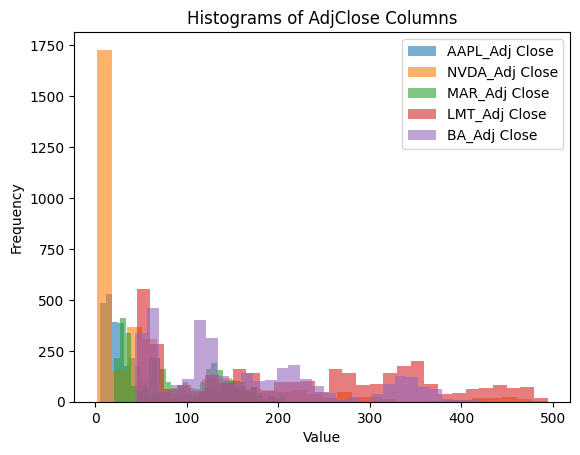

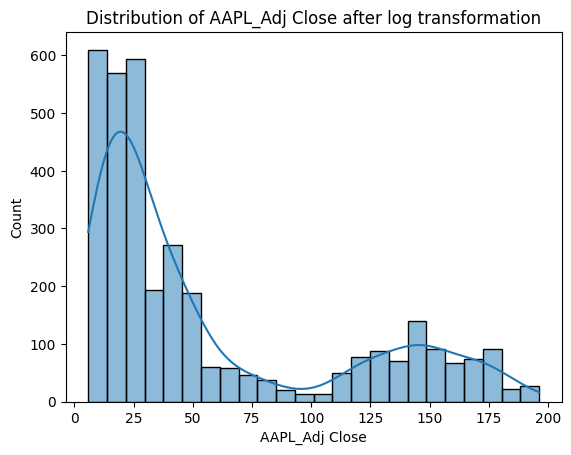

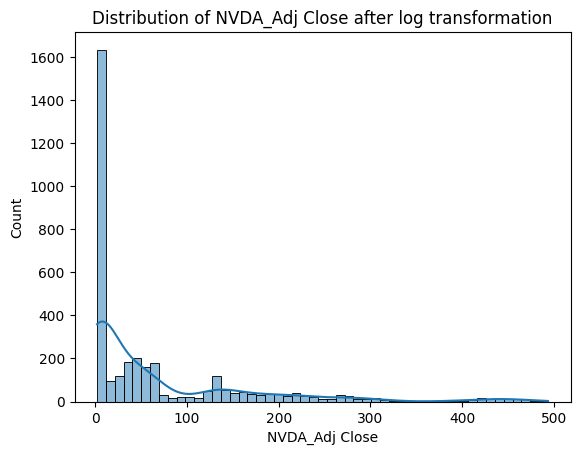

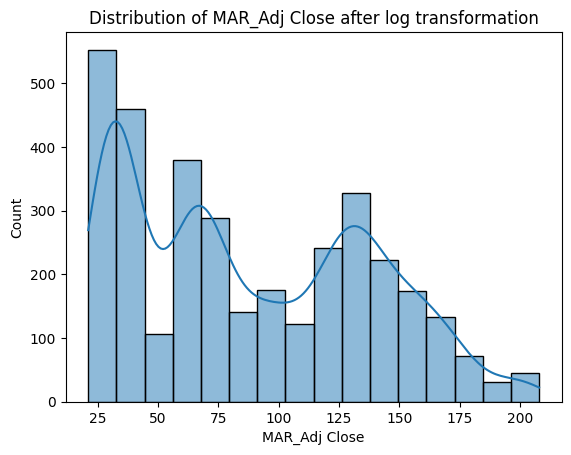

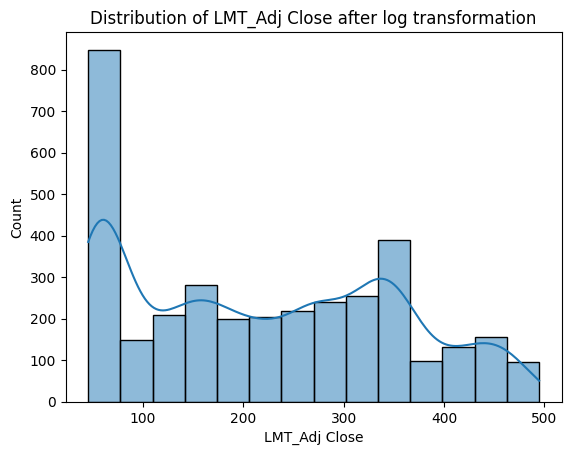

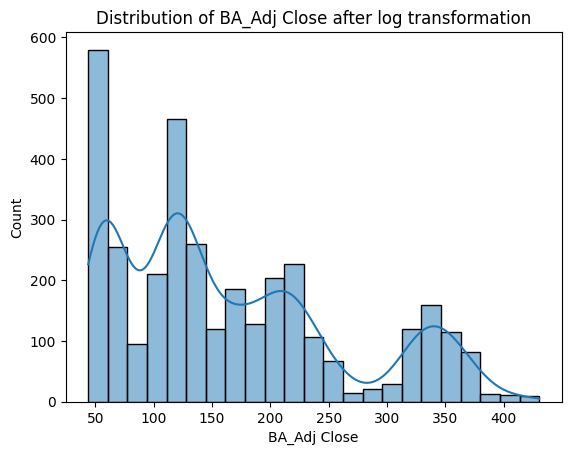

In [462]:
# Using histogram to check data distribution if they are right-skewed (mean>median)

# For Adj Close columns
columns_to_plot = ["AAPL_Adj Close", "NVDA_Adj Close", "MAR_Adj Close", "LMT_Adj Close", "BA_Adj Close"]
for column in columns_to_plot:
    plt.hist(merged[column], bins=30, alpha=0.6, label=column)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograms of AdjClose Columns')
plt.legend(loc='upper right')

# Show the plot
plt.show()


# Identify outliers using Z-score and handle them using log transformation
# Set a common threshold for identifying outliers
threshold = 3  # indicates outliers are data points 3 standard deviations away from the mean

for column_name in columns_to_plot:
    # Calculate the Z-score for the current column
    z_scores = np.abs(stats.zscore(merged[column_name]))

    # Identify outliers based on the Z-score
    outliers = merged[column_name][z_scores > threshold]

    # Apply log transformation to outliers and replace in the DataFrame
    merged.loc[z_scores > threshold, column_name] = np.log1p(outliers)

    # Check the distribution after log transformation
    sns.histplot(merged[column_name], kde=True)
    plt.xlabel(column_name)
    plt.title(f'Distribution of {column_name} after log transformation')
    plt.show()

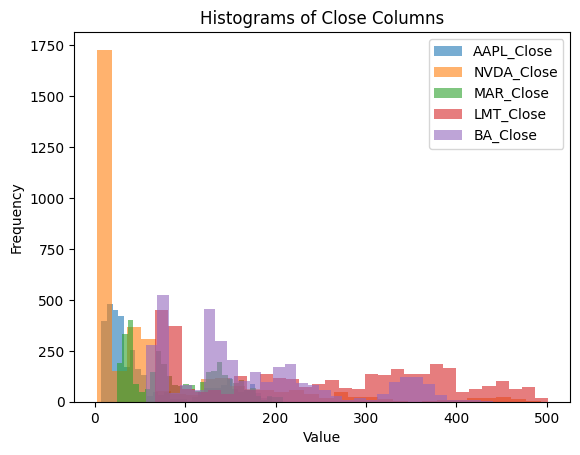

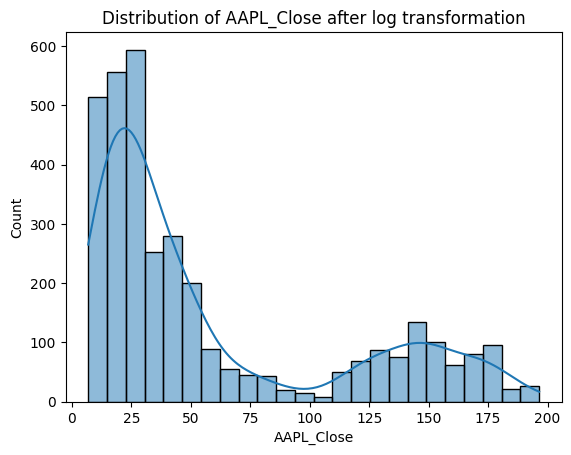

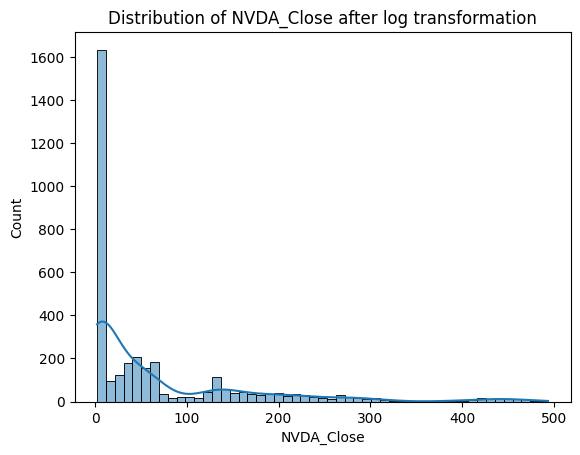

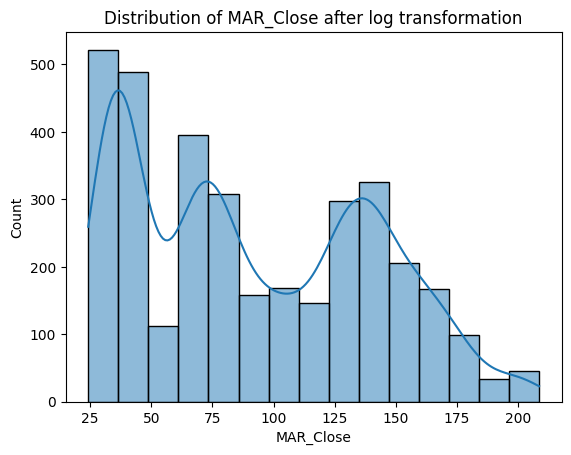

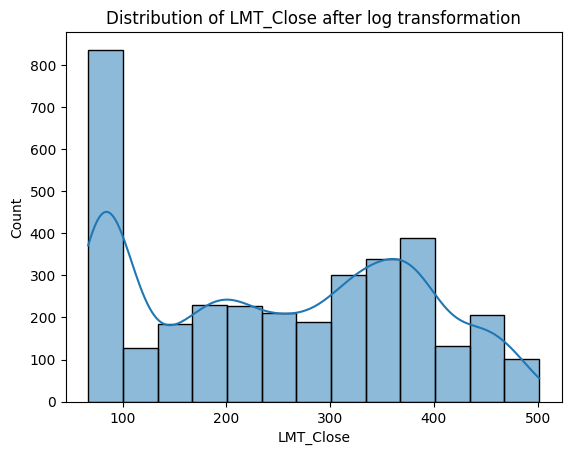

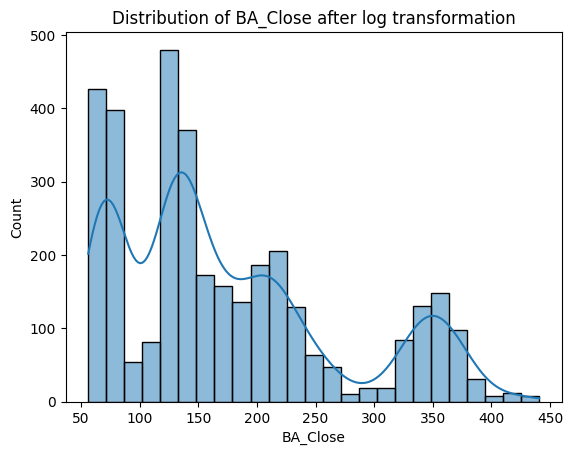

In [463]:
# Using histogram to check data distribution if they are right-skewed (mean>median)

# For Close columns
columns_to_plot = ["AAPL_Close", "NVDA_Close", "MAR_Close", "LMT_Close", "BA_Close"]
for column in columns_to_plot:
    plt.hist(merged[column], bins=30, alpha=0.6, label=column)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograms of Close Columns')
plt.legend(loc='upper right')

# Show the plot
plt.show()


# Identify outliers using Z-score and handle them using log transformation
# Set a common threshold for identifying outliers
threshold = 3  # indicates outliers are data points 3 standard deviations away from the mean

for column_name in columns_to_plot:
    # Calculate the Z-score for the current column
    z_scores = np.abs(stats.zscore(merged[column_name]))

    # Identify outliers based on the Z-score
    outliers = merged[column_name][z_scores > threshold]

    # Apply log transformation to outliers and replace in the DataFrame
    merged.loc[z_scores > threshold, column_name] = np.log1p(outliers)

    # Check the distribution after log transformation
    sns.histplot(merged[column_name], kde=True)
    plt.xlabel(column_name)
    plt.title(f'Distribution of {column_name} after log transformation')
    plt.show()

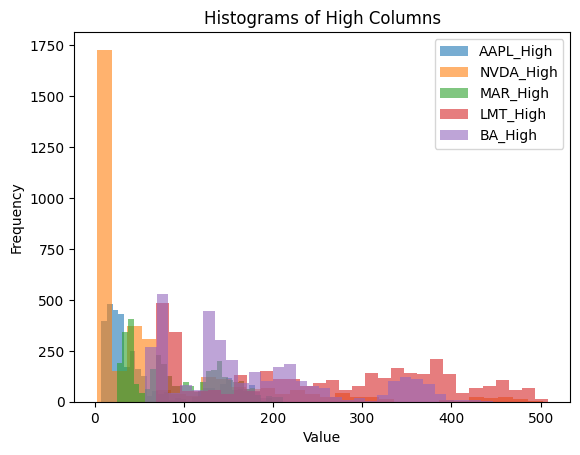

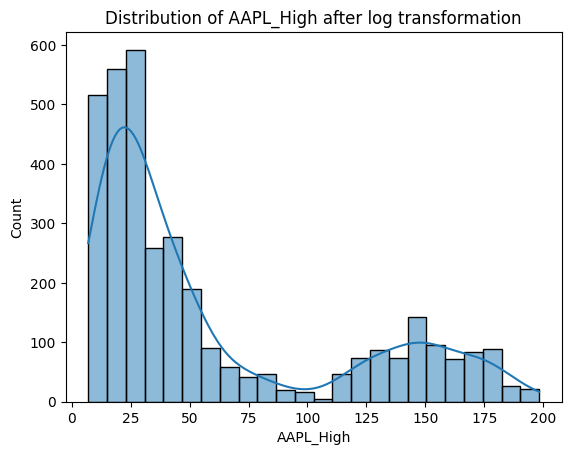

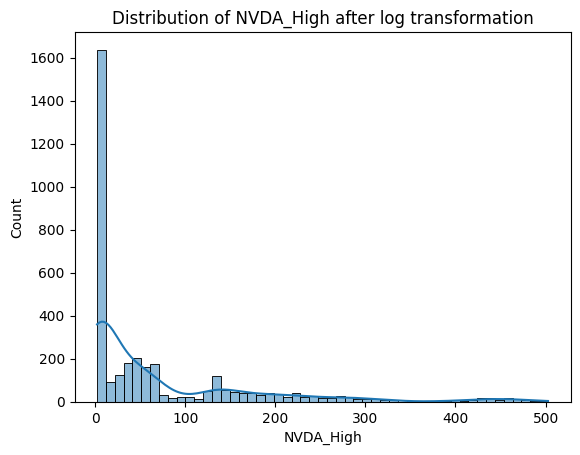

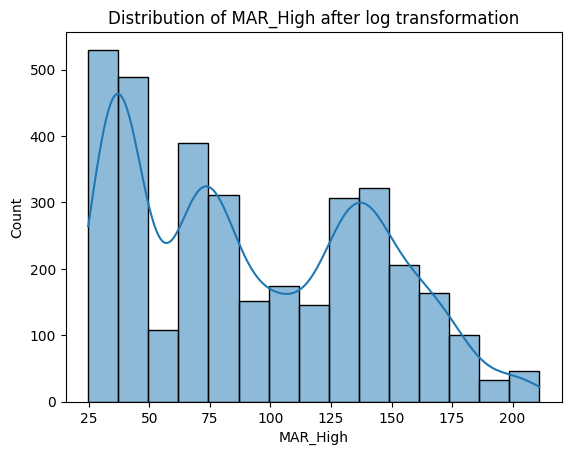

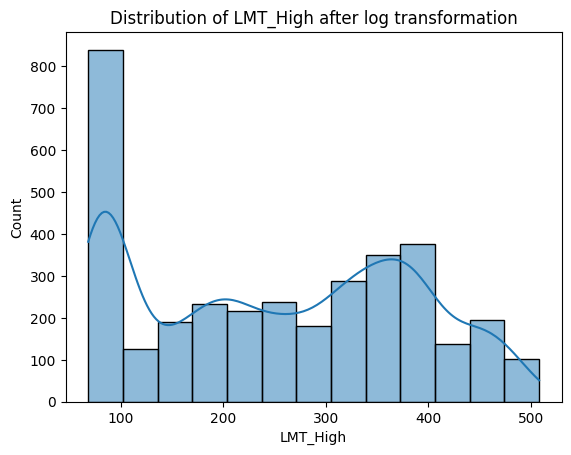

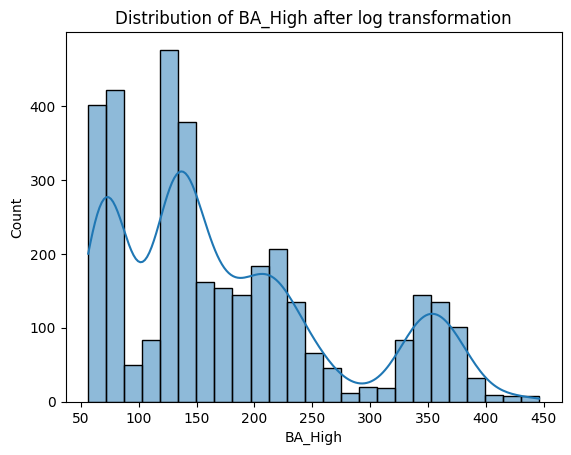

In [464]:
# Using histogram to check data distribution if they are right-skewed (mean>median)

# For High columns
columns_to_plot = ["AAPL_High", "NVDA_High", "MAR_High", "LMT_High", "BA_High"]
for column in columns_to_plot:
    plt.hist(merged[column], bins=30, alpha=0.6, label=column)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograms of High Columns')
plt.legend(loc='upper right')

# Show the plot
plt.show()


# Identify outliers using Z-score and handle them using log transformation
# Set a common threshold for identifying outliers
threshold = 3  # indicates outliers are data points 3 standard deviations away from the mean

for column_name in columns_to_plot:
    # Calculate the Z-score for the current column
    z_scores = np.abs(stats.zscore(merged[column_name]))

    # Identify outliers based on the Z-score
    outliers = merged[column_name][z_scores > threshold]

    # Apply log transformation to outliers and replace in the DataFrame
    merged.loc[z_scores > threshold, column_name] = np.log1p(outliers)

    # Check the distribution after log transformation
    sns.histplot(merged[column_name], kde=True)
    plt.xlabel(column_name)
    plt.title(f'Distribution of {column_name} after log transformation')
    plt.show()

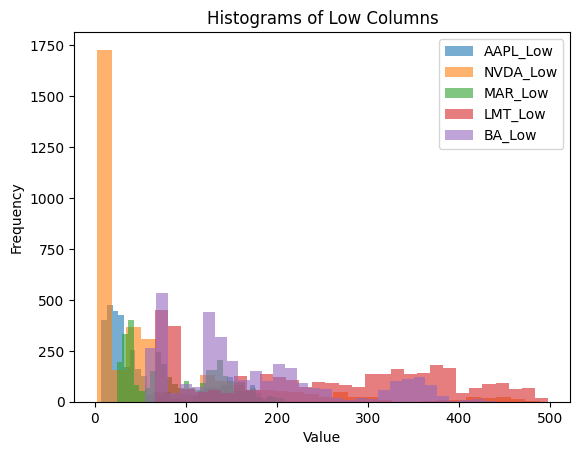

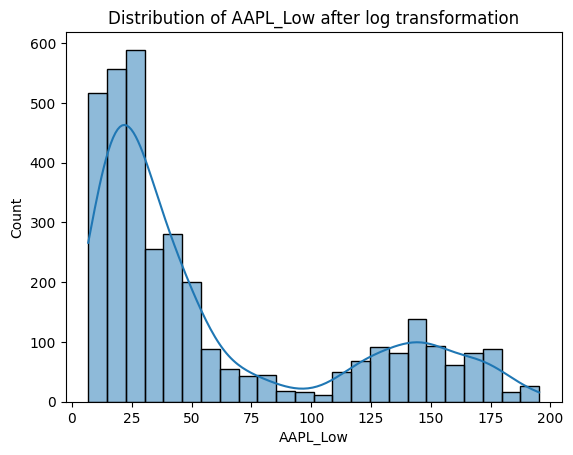

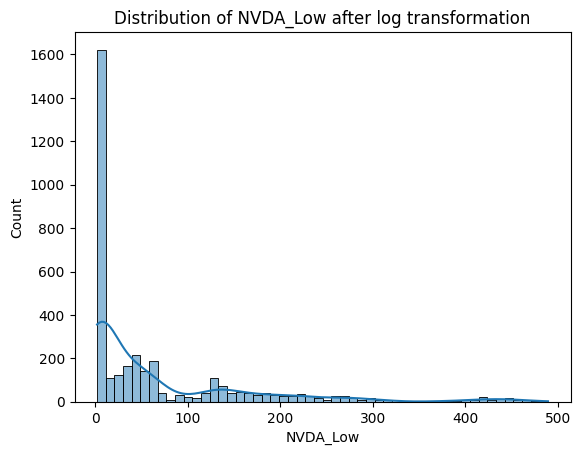

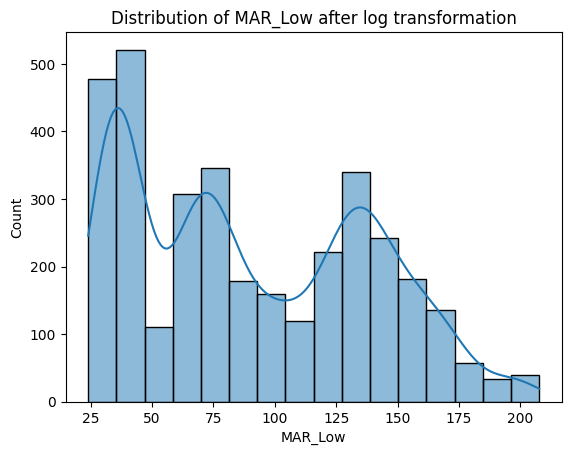

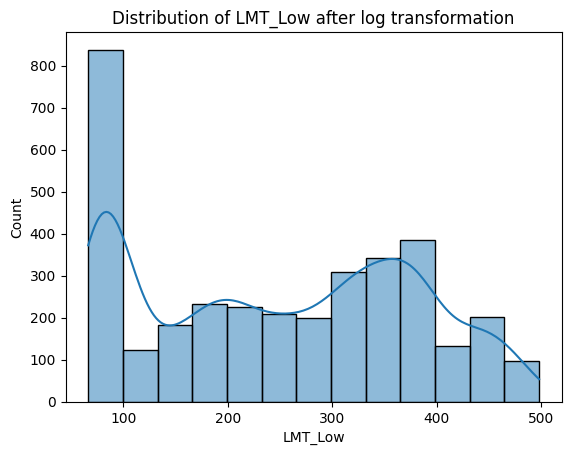

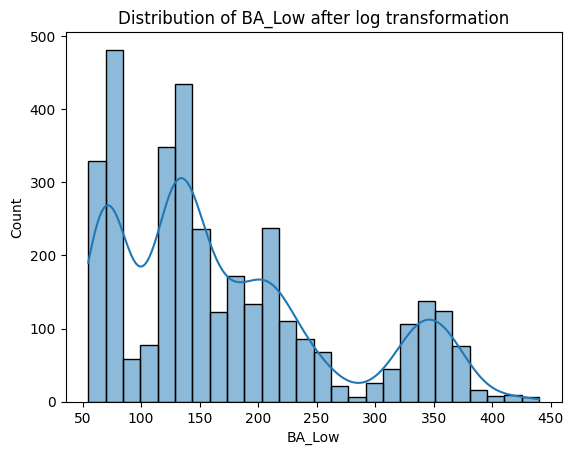

In [465]:
# Using histogram to check data distribution if they are right-skewed (mean>median)

# For Low columns
columns_to_plot = ["AAPL_Low", "NVDA_Low", "MAR_Low", "LMT_Low", "BA_Low"]
for column in columns_to_plot:
    plt.hist(merged[column], bins=30, alpha=0.6, label=column)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograms of Low Columns')
plt.legend(loc='upper right')

# Show the plot
plt.show()


# Identify outliers using Z-score and handle them using log transformation
# Set a common threshold for identifying outliers
threshold = 3  # indicates outliers are data points 3 standard deviations away from the mean

for column_name in columns_to_plot:
    # Calculate the Z-score for the current column
    z_scores = np.abs(stats.zscore(merged[column_name]))

    # Identify outliers based on the Z-score
    outliers = merged[column_name][z_scores > threshold]

    # Apply log transformation to outliers and replace in the DataFrame
    merged.loc[z_scores > threshold, column_name] = np.log1p(outliers)

    # Check the distribution after log transformation
    sns.histplot(merged[column_name], kde=True)
    plt.xlabel(column_name)
    plt.title(f'Distribution of {column_name} after log transformation')
    plt.show()

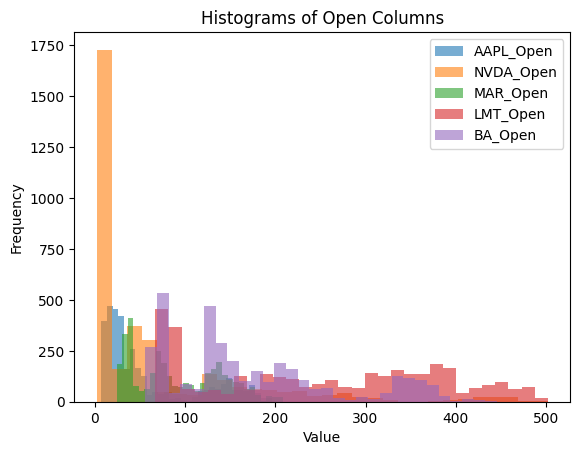

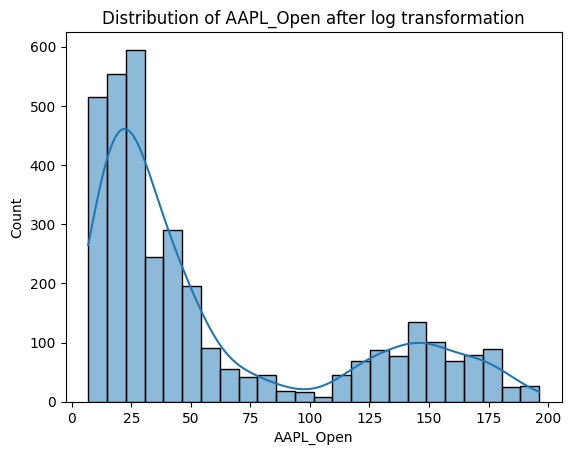

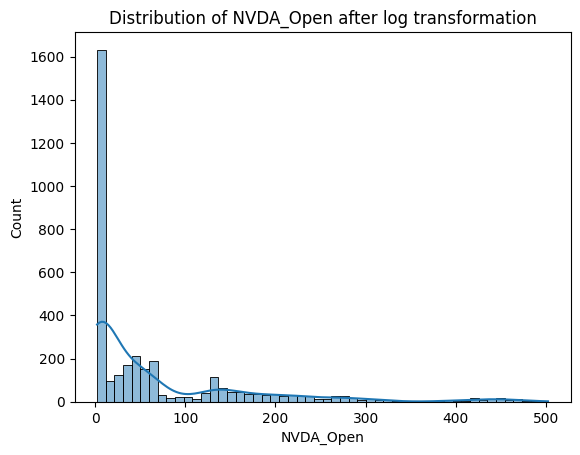

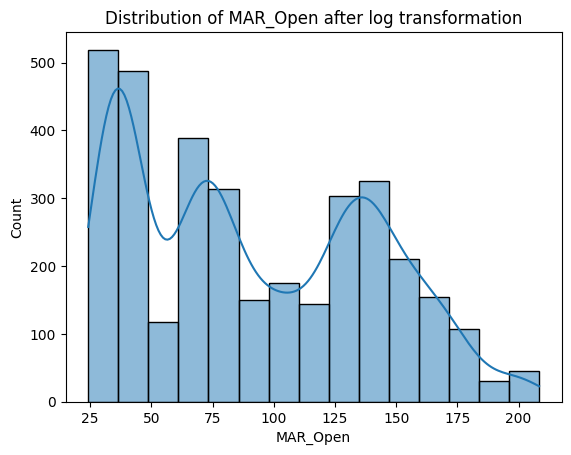

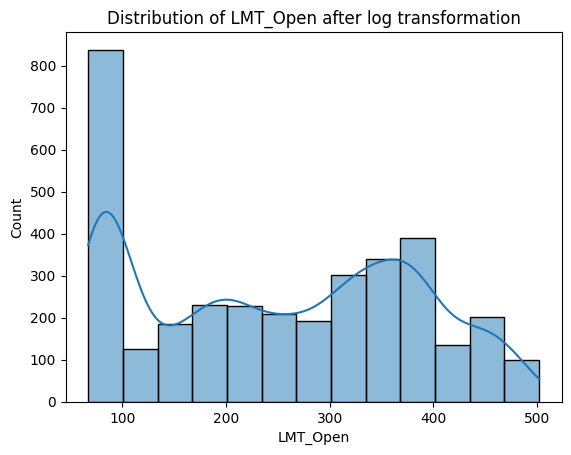

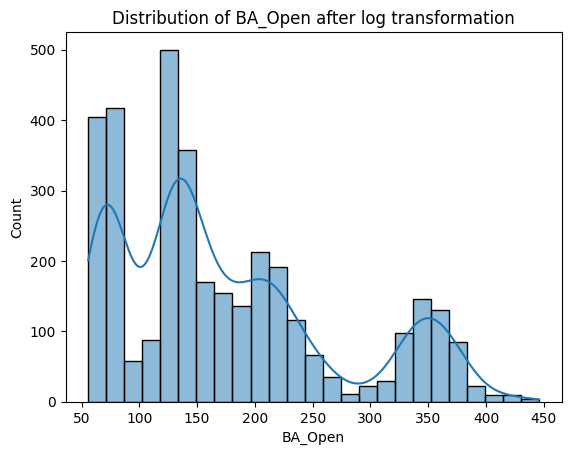

In [466]:
# Using histogram to check data distribution if they are right-skewed (mean>median)

# For High columns
columns_to_plot = ["AAPL_Open", "NVDA_Open", "MAR_Open", "LMT_Open", "BA_Open"]
for column in columns_to_plot:
    plt.hist(merged[column], bins=30, alpha=0.6, label=column)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograms of Open Columns')
plt.legend(loc='upper right')

# Show the plot
plt.show()


# Identify outliers using Z-score and handle them using log transformation
# Set a common threshold for identifying outliers
threshold = 3  # indicates outliers are data points 3 standard deviations away from the mean

for column_name in columns_to_plot:
    # Calculate the Z-score for the current column
    z_scores = np.abs(stats.zscore(merged[column_name]))

    # Identify outliers based on the Z-score
    outliers = merged[column_name][z_scores > threshold]

    # Apply log transformation to outliers and replace in the DataFrame
    merged.loc[z_scores > threshold, column_name] = np.log1p(outliers)

    # Check the distribution after log transformation
    sns.histplot(merged[column_name], kde=True)
    plt.xlabel(column_name)
    plt.title(f'Distribution of {column_name} after log transformation')
    plt.show()

In [467]:
merged        # merged dataframe outliers will now be replaced

,Date,AAPL_Adj Close,AAPL_Close,AAPL_Daily_Return,AAPL_High,AAPL_Low,AAPL_Open,AAPL_Volume,AAPL_Sentiment_score,NVDA_Adj Close,...,LMT_Volume,LMT_Sentiment_score,BA_Adj Close,BA_Close,BA_Daily_Return,BA_High,BA_Low,BA_Open,BA_Volume,BA_Sentiment_score
0,2010-01-04,6.487533,7.643214,NaN,7.660714,7.585000,7.622500,493729600.0,NaN,4.240801,...,2408300.0,NaN,43.777550,56.180000,NaN,56.389999,54.799999,55.720001,6186700.0,NaN
1,2010-01-05,6.498752,7.656429,0.001729,7.699643,7.616071,7.664286,601904800.0,NaN,4.302728,...,2356500.0,NaN,45.211349,58.020000,0.032752,58.279999,56.000000,56.250000,8867800.0,NaN
2,2010-01-06,6.395379,7.534643,-0.015907,7.686786,7.526786,7.656429,552160000.0,NaN,4.330251,...,5208100.0,NaN,46.582802,59.779999,0.030334,59.990002,57.880001,58.230000,8836500.0,NaN
3,2010-01-07,6.383557,7.520714,-0.001848,7.571429,7.466071,7.562500,477131200.0,NaN,4.245387,...,7038300.0,NaN,48.468555,62.200001,0.040482,62.310001,59.020000,59.509998,14379100.0,NaN
4,2010-01-08,6.425997,7.570714,0.006648,7.571429,7.466429,7.510714,447610800.0,NaN,4.254563,...,3629400.0,NaN,48.001019,61.599998,-0.009646,61.779999,60.860001,61.540001,7146600.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3468,2023-10-13,178.850006,178.850006,-0.010293,181.929993,178.139999,181.419998,51427100.0,NaN,454.609985,...,1519300.0,NaN,184.910004,184.910004,-0.033403,187.289993,183.179993,186.270004,8215700.0,NaN
3469,2023-10-16,178.720001,178.720001,-0.000727,179.080002,176.509995,176.750000,52517000.0,NaN,460.950012,...,1931300.0,NaN,184.929993,184.929993,0.000108,186.229996,182.500000,185.910004,4701000.0,NaN
3470,2023-10-17,177.149994,177.149994,-0.008785,178.419998,174.800003,176.649994,57549400.0,NaN,439.380005,...,3103900.0,NaN,185.600006,185.600006,0.003623,188.330002,183.300003,183.750000,5121800.0,NaN
3471,2023-10-18,175.839996,175.839996,-0.007395,177.580002,175.110001,175.580002,54764400.0,NaN,421.959991,...,2024100.0,NaN,185.690002,185.690002,0.000485,190.250000,185.050003,187.220001,6268100.0,NaN


In [468]:
# Check for NaN values in any of the columns (except sentiment_score)
# 1st NaN row: first row for Daily_Return  (because there's no return on 'first day')
# 2nd NaN row: I have found out that the NaN value comes from the row 2356 in excel => which is due to: an earnings call by MAR was done on a Saturday (2019-05-11)

# Will be using zero fill to replace (Assume no return on first day) 1st NaN row for "Daily_Return" columns, Using Median to replace 1st NaN row of other columns,

# Check for NaN values in all columns of the DataFrame and count them
nan_counts = merged.isna().sum()

# Display columns with NaN values and the count of NaN values
columns_with_nan = nan_counts[nan_counts > 0]
print(columns_with_nan)


zero_fill_columns = ["AAPL_Daily_Return", "NVDA_Daily_Return", "MAR_Daily_Return", "LMT_Daily_Return", "BA_Daily_Return"]
for column in zero_fill_columns:
    if merged[column].isna().any():
        first_nan_index = merged[column].index[merged[column].isna()].tolist()[0]         # Only for the first row of Daily_Return columns

        merged.at[first_nan_index, column] = 0


# Display columns with NaN values and the count of NaN values
nan_counts = merged.isna().sum()
columns_with_nan = nan_counts[nan_counts > 0]
print(columns_with_nan)

columns_to_replace_outliers = ["AAPL_Adj Close", "AAPL_Close", "AAPL_Daily_Return", "AAPL_High", "AAPL_Low", "AAPL_Open", "AAPL_Volume",
                               "NVDA_Adj Close", "NVDA_Close", "NVDA_Daily_Return", "NVDA_High", "NVDA_Low", "NVDA_Open", "NVDA_Volume",
                               "MAR_Adj Close", "MAR_Close", "MAR_Daily_Return", "MAR_High", "MAR_Low", "MAR_Open", "MAR_Volume",
                               "LMT_Adj Close", "LMT_Close", "LMT_Daily_Return", "LMT_High", "LMT_Low", "LMT_Open", "LMT_Volume",
                               "BA_Adj Close", "BA_Close", "BA_Daily_Return", "BA_High", "BA_Low", "BA_Open", "BA_Volume",
                               ]


# Function that replaces NaN values of column with median
def replace_nan_with_median(df, columns_to_process):
    for column in columns_to_process:
        median = df[column].median()
        df[column].fillna(median, inplace=True)
    return df

merged = replace_nan_with_median(merged, columns_to_replace_outliers)

print(merged)


AAPL_Adj Close             1
AAPL_Close                 1
AAPL_Daily_Return          2
AAPL_High                  1
AAPL_Low                   1
AAPL_Open                  1
AAPL_Volume                1
AAPL_Sentiment_score    3419
NVDA_Adj Close             1
NVDA_Close                 1
NVDA_Daily_Return          2
NVDA_High                  1
NVDA_Low                   1
NVDA_Open                  1
NVDA_Volume                1
NVDA_Sentiment_score    3419
MAR_Adj Close              1
MAR_Close                  1
MAR_Daily_Return           2
MAR_High                   1
MAR_Low                    1
MAR_Open                   1
MAR_Volume                 1
MAR_Sentiment_score     3419
LMT_Adj Close              1
LMT_Close                  1
LMT_Daily_Return           2
LMT_High                   1
LMT_Low                    1
LMT_Open                   1
LMT_Volume                 1
LMT_Sentiment_score     3420
BA_Adj Close               1
BA_Close                   1
BA_Daily_Retur

In [469]:
# Interpolate the sentiment scores for all 5 stocks for those non earnings call dates using linear interpolation
columns_to_interpolate = ['AAPL_Sentiment_score', 'NVDA_Sentiment_score', 'MAR_Sentiment_score', 'LMT_Sentiment_score', 'BA_Sentiment_score']  # Replace with your column names
for column in columns_to_interpolate:
    merged[column].interpolate(method='linear', inplace=True)

merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3474 entries, 0 to 3472
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  3474 non-null   object 
 1   AAPL_Adj Close        3474 non-null   float64
 2   AAPL_Close            3474 non-null   float64
 3   AAPL_Daily_Return     3474 non-null   float64
 4   AAPL_High             3474 non-null   float64
 5   AAPL_Low              3474 non-null   float64
 6   AAPL_Open             3474 non-null   float64
 7   AAPL_Volume           3474 non-null   float64
 8   AAPL_Sentiment_score  3459 non-null   float64
 9   NVDA_Adj Close        3474 non-null   float64
 10  NVDA_Close            3474 non-null   float64
 11  NVDA_Daily_Return     3474 non-null   float64
 12  NVDA_High             3474 non-null   float64
 13  NVDA_Low              3474 non-null   float64
 14  NVDA_Open             3474 non-null   float64
 15  NVDA_Volume          

In [470]:
#Display columns with NaN values and the count of NaN values
nan_counts = merged.isna().sum()
columns_with_nan = nan_counts[nan_counts > 0]
print(columns_with_nan)

# Since there are still leftover NaN for sentiment score column, possibly due to presence of consecutive NaN values, I will use backfill to handle them
columns_to_backfill = ['AAPL_Sentiment_score', 'NVDA_Sentiment_score', 'MAR_Sentiment_score', 'LMT_Sentiment_score', 'BA_Sentiment_score']
for column in columns_to_backfill:
    merged[column].fillna(method='bfill', inplace=True)

merged.tail(50)

# Confirm there is no leftover NaN values
nan_counts_new = merged.isna().sum()
columns_with_nan_new = nan_counts_new[nan_counts > 0]
print(columns_with_nan_new)

AAPL_Sentiment_score    15
NVDA_Sentiment_score    31
MAR_Sentiment_score     27
LMT_Sentiment_score     18
BA_Sentiment_score      16
dtype: int64
AAPL_Sentiment_score    0
NVDA_Sentiment_score    0
MAR_Sentiment_score     0
LMT_Sentiment_score     0
BA_Sentiment_score      0
dtype: int64


In [471]:
merged

,Date,AAPL_Adj Close,AAPL_Close,AAPL_Daily_Return,AAPL_High,AAPL_Low,AAPL_Open,AAPL_Volume,AAPL_Sentiment_score,NVDA_Adj Close,...,LMT_Volume,LMT_Sentiment_score,BA_Adj Close,BA_Close,BA_Daily_Return,BA_High,BA_Low,BA_Open,BA_Volume,BA_Sentiment_score
0,2010-01-04,6.487533,7.643214,0.000000,7.660714,7.585000,7.622500,493729600.0,0.189922,4.240801,...,2408300.0,0.123229,43.777550,56.180000,0.000000,56.389999,54.799999,55.720001,6186700.0,0.118022
1,2010-01-05,6.498752,7.656429,0.001729,7.699643,7.616071,7.664286,601904800.0,0.189922,4.302728,...,2356500.0,0.123229,45.211349,58.020000,0.032752,58.279999,56.000000,56.250000,8867800.0,0.118022
2,2010-01-06,6.395379,7.534643,-0.015907,7.686786,7.526786,7.656429,552160000.0,0.189922,4.330251,...,5208100.0,0.123229,46.582802,59.779999,0.030334,59.990002,57.880001,58.230000,8836500.0,0.118022
3,2010-01-07,6.383557,7.520714,-0.001848,7.571429,7.466071,7.562500,477131200.0,0.189922,4.245387,...,7038300.0,0.123229,48.468555,62.200001,0.040482,62.310001,59.020000,59.509998,14379100.0,0.118022
4,2010-01-08,6.425997,7.570714,0.006648,7.571429,7.466429,7.510714,447610800.0,0.189922,4.254563,...,3629400.0,0.123229,48.001019,61.599998,-0.009646,61.779999,60.860001,61.540001,7146600.0,0.118022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3468,2023-10-13,178.850006,178.850006,-0.010293,181.929993,178.139999,181.419998,51427100.0,0.300216,454.609985,...,1519300.0,0.234343,184.910004,184.910004,-0.033403,187.289993,183.179993,186.270004,8215700.0,0.207792
3469,2023-10-16,178.720001,178.720001,-0.000727,179.080002,176.509995,176.750000,52517000.0,0.300216,460.950012,...,1931300.0,0.234343,184.929993,184.929993,0.000108,186.229996,182.500000,185.910004,4701000.0,0.207792
3470,2023-10-17,177.149994,177.149994,-0.008785,178.419998,174.800003,176.649994,57549400.0,0.300216,439.380005,...,3103900.0,0.234343,185.600006,185.600006,0.003623,188.330002,183.300003,183.750000,5121800.0,0.207792
3471,2023-10-18,175.839996,175.839996,-0.007395,177.580002,175.110001,175.580002,54764400.0,0.300216,421.959991,...,2024100.0,0.234343,185.690002,185.690002,0.000485,190.250000,185.050003,187.220001,6268100.0,0.207792


In [472]:
# Add additional features: Technical indicators to measure price momentum

portfolio_stocks = ["AAPL", "NVDA", "MAR", "LMT", "BA"]

def add_technical_indicators(df, stock_symbol):
    # Calculate historical volatility
    df[f'{stock_symbol}_Volatility'] = df[f'{stock_symbol}_Close'].rolling(window=21).std()

    # Calculate Simple Moving Average (SMA)
    df[f'{stock_symbol}_SMA'] = df[f'{stock_symbol}_Close'].rolling(window=14).mean()

    # Calculate Upper Bollinger Band
    df[f'{stock_symbol}_Upper_Bollinger'] = df[f'{stock_symbol}_SMA'] + 2 * df[f'{stock_symbol}_Volatility']

    # Calculate Lower Bollinger Band
    df[f'{stock_symbol}_Lower_Bollinger'] = df[f'{stock_symbol}_SMA'] - 2 * df[f'{stock_symbol}_Volatility']

    # Calculate Moving Average Convergence Divergence (MACD)
    df[f'{stock_symbol}_MACD'] = df[f'{stock_symbol}_Close'].rolling(window=12).mean() - df[f'{stock_symbol}_Close'].rolling(window=26).mean()

    # Calculate Relative Strength Index (RSI)
    delta = df[f'{stock_symbol}_Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    df[f'{stock_symbol}_RSI'] = rsi

for each_stock in portfolio_stocks:
    add_technical_indicators(merged, each_stock)

merged

,Date,AAPL_Adj Close,AAPL_Close,AAPL_Daily_Return,AAPL_High,AAPL_Low,AAPL_Open,AAPL_Volume,AAPL_Sentiment_score,NVDA_Adj Close,...,LMT_Upper_Bollinger,LMT_Lower_Bollinger,LMT_MACD,LMT_RSI,BA_Volatility,BA_SMA,BA_Upper_Bollinger,BA_Lower_Bollinger,BA_MACD,BA_RSI
0,2010-01-04,6.487533,7.643214,0.000000,7.660714,7.585000,7.622500,493729600.0,0.189922,4.240801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,6.498752,7.656429,0.001729,7.699643,7.616071,7.664286,601904800.0,0.189922,4.302728,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-06,6.395379,7.534643,-0.015907,7.686786,7.526786,7.656429,552160000.0,0.189922,4.330251,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-07,6.383557,7.520714,-0.001848,7.571429,7.466071,7.562500,477131200.0,0.189922,4.245387,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-08,6.425997,7.570714,0.006648,7.571429,7.466429,7.510714,447610800.0,0.189922,4.254563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3468,2023-10-13,178.850006,178.850006,-0.010293,181.929993,178.139999,181.419998,51427100.0,0.300216,454.609985,...,443.919364,389.213492,-0.999486,69.659342,6.855374,190.332857,204.043605,176.622110,-7.904358,31.802690
3469,2023-10-16,178.720001,178.720001,-0.000727,179.080002,176.509995,176.750000,52517000.0,0.300216,460.950012,...,447.766578,389.889136,0.788527,73.238438,6.377148,189.567857,202.322152,176.813562,-7.349614,34.695620
3470,2023-10-17,177.149994,177.149994,-0.008785,178.419998,174.800003,176.649994,57549400.0,0.300216,439.380005,...,451.320599,390.965116,2.682054,73.550391,5.968152,188.863571,200.799875,176.927267,-6.878973,36.104857
3471,2023-10-18,175.839996,175.839996,-0.007395,177.580002,175.110001,175.580002,54764400.0,0.300216,421.959991,...,455.913803,391.387628,4.783399,74.549053,5.437031,188.525000,199.399062,177.650939,-6.097306,42.239704


In [473]:
# Check NaN counts for the additional technical indicators columns
# Display columns with NaN values and the count of NaN values
nan_counts = merged.isna().sum()
columns_with_nan = nan_counts[nan_counts > 0]
print(columns_with_nan)

AAPL_Volatility         20
AAPL_SMA                13
AAPL_Upper_Bollinger    20
AAPL_Lower_Bollinger    20
AAPL_MACD               25
AAPL_RSI                13
NVDA_Volatility         20
NVDA_SMA                13
NVDA_Upper_Bollinger    20
NVDA_Lower_Bollinger    20
NVDA_MACD               25
NVDA_RSI                13
MAR_Volatility          20
MAR_SMA                 13
MAR_Upper_Bollinger     20
MAR_Lower_Bollinger     20
MAR_MACD                25
MAR_RSI                 13
LMT_Volatility          20
LMT_SMA                 13
LMT_Upper_Bollinger     20
LMT_Lower_Bollinger     20
LMT_MACD                25
LMT_RSI                 13
BA_Volatility           20
BA_SMA                  13
BA_Upper_Bollinger      20
BA_Lower_Bollinger      20
BA_MACD                 25
BA_RSI                  13
dtype: int64


In [474]:
# Using backfill interpolation to fill up the NaN values for the above columns, useful for consecutive NaN values
nan_technical_indicators = merged.isna()
for column in nan_technical_indicators:
    merged[column].interpolate(method='bfill', inplace=True)

# Check if there are still NaN values
new_nan_counts = merged.isna().sum()
new_columns_with_nan = new_nan_counts[new_nan_counts > 0]
print(new_columns_with_nan)
print('\n')

# Confrim no leftover NaN values for all columns in dataframe
print(merged.isna().sum())

Series([], dtype: int64)


Date                  0
AAPL_Adj Close        0
AAPL_Close            0
AAPL_Daily_Return     0
AAPL_High             0
                     ..
BA_SMA                0
BA_Upper_Bollinger    0
BA_Lower_Bollinger    0
BA_MACD               0
BA_RSI                0
Length: 71, dtype: int64


In [475]:
# Standardize features so that they have mean of 0 and std of 1, ensure all features are on a similar scale
# Define the columns you want to standardize (excluding non-numeric columns)
columns_to_standardize = merged.select_dtypes(include=[np.number]).columns.tolist()

# Create a StandardScaler instance
scaler = StandardScaler()

# Standardize the selected columns
merged[columns_to_standardize] = scaler.fit_transform(merged[columns_to_standardize])

In [476]:
merged

,Date,AAPL_Adj Close,AAPL_Close,AAPL_Daily_Return,AAPL_High,AAPL_Low,AAPL_Open,AAPL_Volume,AAPL_Sentiment_score,NVDA_Adj Close,...,LMT_Upper_Bollinger,LMT_Lower_Bollinger,LMT_MACD,LMT_RSI,BA_Volatility,BA_SMA,BA_Upper_Bollinger,BA_Lower_Bollinger,BA_MACD,BA_RSI
0,2010-01-04,-0.917649,-0.940025,-0.062172,-0.940606,-0.940167,-0.940594,1.126903,-1.183856,-0.635539,...,-1.338005,-1.334536,-0.169234,-0.572289,-0.593046,-1.207920,-1.192660,-1.193159,-0.030447,0.196835
1,2010-01-05,-0.917442,-0.939779,0.034762,-0.939889,-0.939582,-0.939815,1.616857,-1.183856,-0.634913,...,-1.338005,-1.334536,-0.169234,-0.572289,-0.593046,-1.207920,-1.192660,-1.193159,-0.030447,0.196835
2,2010-01-06,-0.919351,-0.942046,-0.953755,-0.940126,-0.941264,-0.939961,1.391549,-1.183856,-0.634634,...,-1.338005,-1.334536,-0.169234,-0.572289,-0.593046,-1.207920,-1.192660,-1.193159,-0.030447,0.196835
3,2010-01-07,-0.919570,-0.942306,-0.165781,-0.942251,-0.942408,-0.941712,1.051724,-1.183856,-0.635493,...,-1.338005,-1.334536,-0.169234,-0.572289,-0.593046,-1.207920,-1.192660,-1.193159,-0.030447,0.196835
4,2010-01-08,-0.918786,-0.941375,0.310477,-0.942251,-0.942401,-0.942677,0.918018,-1.183856,-0.635400,...,-1.338005,-1.334536,-0.169234,-0.572289,-0.593046,-1.207920,-1.192660,-1.193159,-0.030447,0.196835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3468,2023-10-13,2.266052,2.247853,-0.639089,2.269481,2.273524,2.298654,-0.876402,1.096190,3.918482,...,1.343051,1.221308,-0.272759,0.954275,0.088984,0.179123,0.177524,0.177356,-1.057570,-1.253588
3469,2023-10-16,2.263650,2.245432,-0.102915,2.216983,2.242811,2.211614,-0.871465,1.096190,3.982591,...,1.371290,1.226796,0.017191,1.168799,0.024632,0.170979,0.160685,0.179547,-0.985750,-1.081989
3470,2023-10-17,2.234651,2.216199,-0.554564,2.204826,2.210590,2.209750,-0.848672,1.096190,3.764480,...,1.397378,1.235534,0.324252,1.187497,-0.030403,0.163482,0.145794,0.180847,-0.924819,-0.998398
3471,2023-10-18,2.210454,2.191807,-0.476660,2.189353,2.216432,2.189807,-0.861286,1.096190,3.588334,...,1.431093,1.238966,0.665013,1.247355,-0.101873,0.159878,0.132091,0.189126,-0.823621,-0.634500


#Performing Data Visualization to provide context for feature selection process

In [477]:
# See all columns in dataframe
merged.columns.values

array(['Date', 'AAPL_Adj Close', 'AAPL_Close', 'AAPL_Daily_Return',
       'AAPL_High', 'AAPL_Low', 'AAPL_Open', 'AAPL_Volume',
       'AAPL_Sentiment_score', 'NVDA_Adj Close', 'NVDA_Close',
       'NVDA_Daily_Return', 'NVDA_High', 'NVDA_Low', 'NVDA_Open',
       'NVDA_Volume', 'NVDA_Sentiment_score', 'MAR_Adj Close',
       'MAR_Close', 'MAR_Daily_Return', 'MAR_High', 'MAR_Low', 'MAR_Open',
       'MAR_Volume', 'MAR_Sentiment_score', 'LMT_Adj Close', 'LMT_Close',
       'LMT_Daily_Return', 'LMT_High', 'LMT_Low', 'LMT_Open',
       'LMT_Volume', 'LMT_Sentiment_score', 'BA_Adj Close', 'BA_Close',
       'BA_Daily_Return', 'BA_High', 'BA_Low', 'BA_Open', 'BA_Volume',
       'BA_Sentiment_score', 'AAPL_Volatility', 'AAPL_SMA',
       'AAPL_Upper_Bollinger', 'AAPL_Lower_Bollinger', 'AAPL_MACD',
       'AAPL_RSI', 'NVDA_Volatility', 'NVDA_SMA', 'NVDA_Upper_Bollinger',
       'NVDA_Lower_Bollinger', 'NVDA_MACD', 'NVDA_RSI', 'MAR_Volatility',
       'MAR_SMA', 'MAR_Upper_Bollinger', 'MAR_Lowe

In [478]:
### TO BE EDITED: After dataframe is back to multiindex, then can use plotly.express to plot interactive scatter matrix to see relationship of columns for each stock

# Select a subset of columns for visualization => Correlation Analysis
# selected_columns = [
#     'AAPL_Adj Close', 'AAPL_Close', 'AAPL_Daily_Return', 'AAPL_High', 'AAPL_Low', 'AAPL_Open',
#     'NVDA_Adj Close', 'NVDA_Close', 'NVDA_Daily_Return', 'NVDA_High', 'NVDA_Low', 'NVDA_Open',
#     'MAR_Adj Close', 'MAR_Close', 'MAR_Daily_Return', 'MAR_High', 'MAR_Low', 'MAR_Open'
# ]

# Create an interactive scatter matrix


# fig = px.scatter_matrix(merged, dimensions=selected_columns, color="AAPL_Adj Close", title="Stock Data Relationships")
# fig.update_traces(marker=dict(size=3), selector=dict(mode='markers'))
# fig.show()

# Feature Selection using xgboost

In [479]:
# Using xgboost model for feature selection, to select most important features for LSTM Model training
feature_columns_AAPL = ['AAPL_Adj Close', 'AAPL_Close', 'AAPL_Daily_Return',
       'AAPL_High', 'AAPL_Low', 'AAPL_Open', 'AAPL_Volume',
       'AAPL_Sentiment_score', 'AAPL_Volatility', 'AAPL_SMA',
       'AAPL_Upper_Bollinger', 'AAPL_Lower_Bollinger', 'AAPL_MACD',
       'AAPL_RSI']

feature_columns_NVDA = ['NVDA_Adj Close', 'NVDA_Close',
       'NVDA_Daily_Return', 'NVDA_High', 'NVDA_Low', 'NVDA_Open',
       'NVDA_Volume', 'NVDA_Sentiment_score', 'NVDA_Volatility', 'NVDA_SMA', 'NVDA_Upper_Bollinger',
       'NVDA_Lower_Bollinger', 'NVDA_MACD', 'NVDA_RSI']


feature_columns_MAR = ['MAR_Adj Close',
       'MAR_Close', 'MAR_Daily_Return', 'MAR_High', 'MAR_Low', 'MAR_Open',
       'MAR_Volume', 'MAR_Sentiment_score', 'MAR_Volatility',
       'MAR_SMA', 'MAR_Upper_Bollinger', 'MAR_Lower_Bollinger',
       'MAR_MACD', 'MAR_RSI']


feature_columns_LMT = [ 'LMT_Adj Close', 'LMT_Close',
       'LMT_Daily_Return', 'LMT_High', 'LMT_Low', 'LMT_Open',
       'LMT_Volume', 'LMT_Sentiment_score',  'LMT_Volatility', 'LMT_SMA',
       'LMT_Upper_Bollinger', 'LMT_Lower_Bollinger', 'LMT_MACD',
       'LMT_RSI']


feature_columns_BA = ['BA_Adj Close', 'BA_Close',
       'BA_Daily_Return', 'BA_High', 'BA_Low', 'BA_Open', 'BA_Volume',
       'BA_Sentiment_score', 'BA_Volatility', 'BA_SMA', 'BA_Upper_Bollinger',
       'BA_Lower_Bollinger', 'BA_MACD', 'BA_RSI']


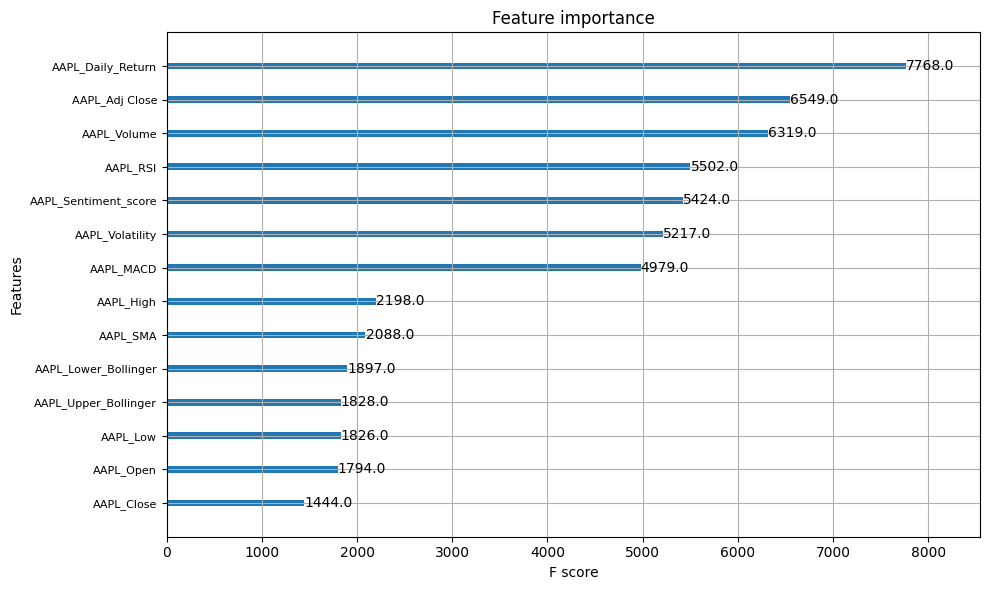

In [480]:
# For AAPL
X = merged[feature_columns_AAPL]

# Train an XGBoost Regressor
model = XGBRegressor()
model.fit(X, X)  # Use the same features for both X and y => Unsupervised feature selection

# Plot feature importances
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(model, ax=ax)

# Adjust font size and spacing for y-axis labels
plt.yticks(fontsize=8)
plt.tight_layout()  # Prevent labels from being cut off

plt.show()

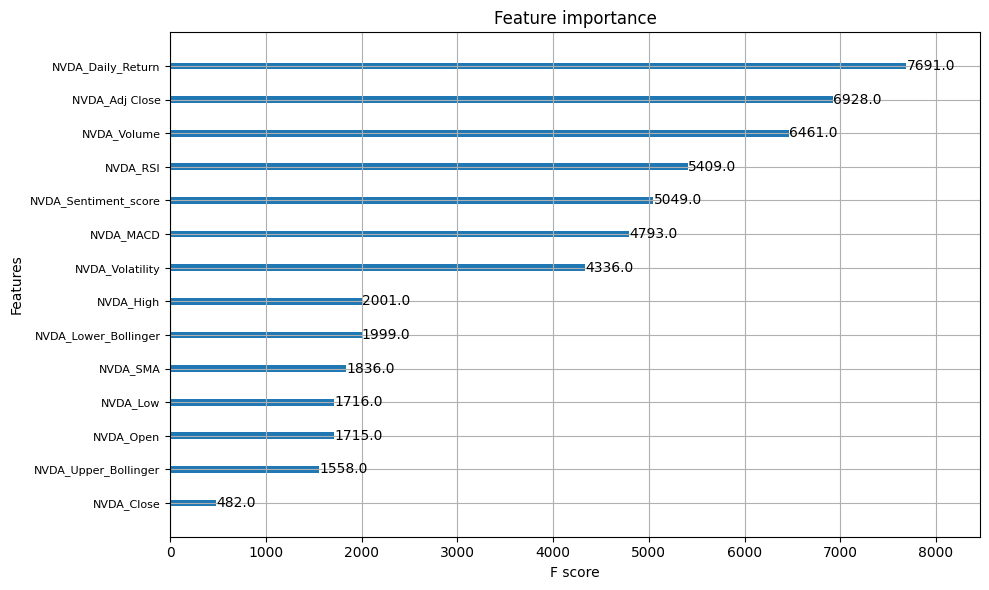

In [481]:
# For NVDA
X = merged[feature_columns_NVDA]

# Train an XGBoost Regressor
model = XGBRegressor()
model.fit(X, X)  # Use the same features for both X and y => Unsupervised feature selection

# Plot feature importances
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(model, ax=ax)

# Adjust font size and spacing for y-axis labels
plt.yticks(fontsize=8)
plt.tight_layout()  # Prevent labels from being cut off

plt.show()

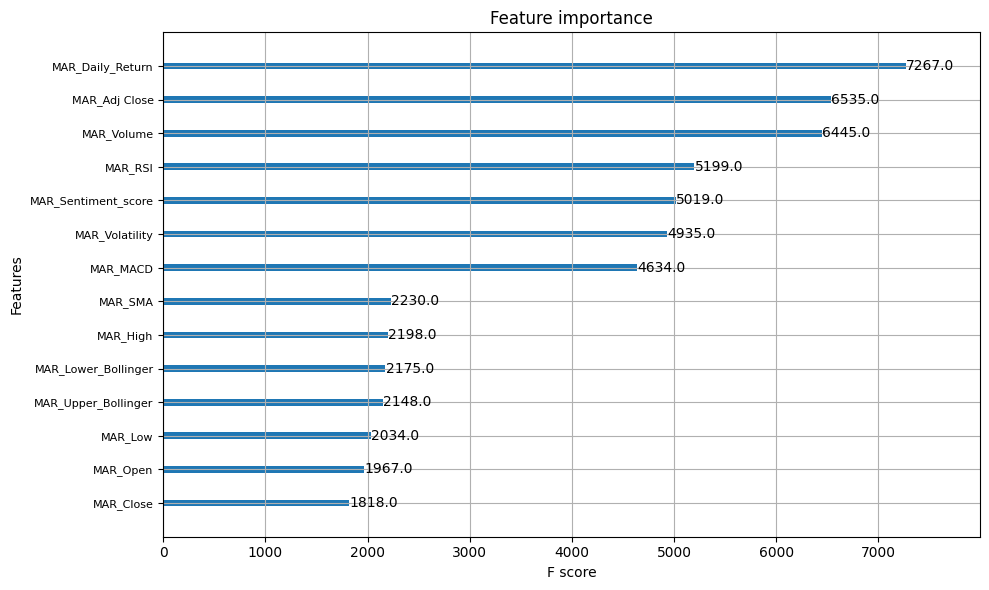

In [482]:
# For MAR
X = merged[feature_columns_MAR]

# Train an XGBoost Regressor
model = XGBRegressor()
model.fit(X, X)  # Use the same features for both X and y => Unsupervised feature selection

# Plot feature importances
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(model, ax=ax)

# Adjust font size and spacing for y-axis labels
plt.yticks(fontsize=8)
plt.tight_layout()  # Prevent labels from being cut off

plt.show()

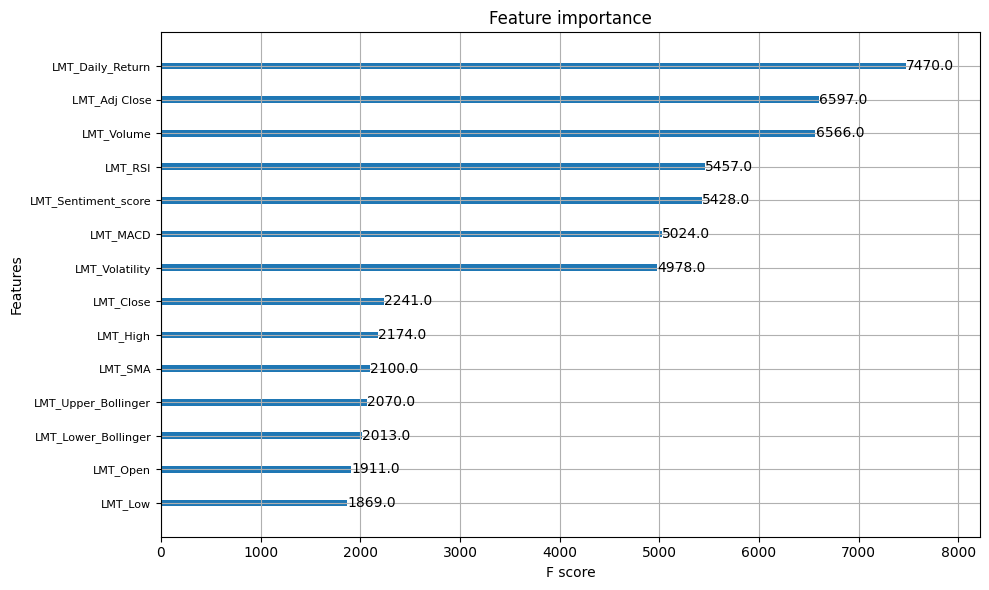

In [483]:
# For LMT
X = merged[feature_columns_LMT]

# Train an XGBoost Regressor
model = XGBRegressor()
model.fit(X, X)  # Use the same features for both X and y => Unsupervised feature selection

# Plot feature importances
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(model, ax=ax)

# Adjust font size and spacing for y-axis labels
plt.yticks(fontsize=8)
plt.tight_layout()  # Prevent labels from being cut off

plt.show()

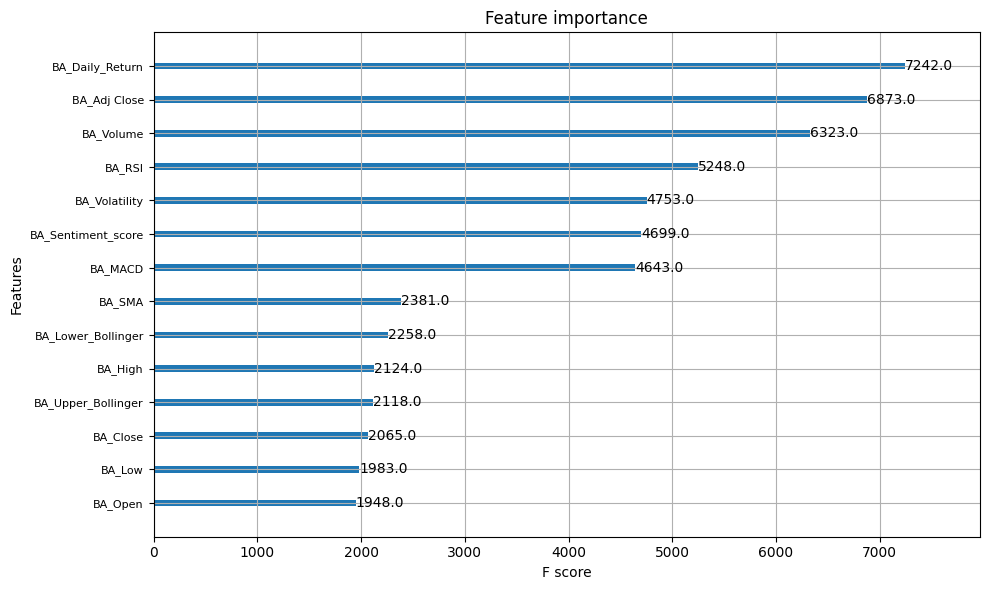

In [484]:
# For BA
X = merged[feature_columns_BA]

# Train an XGBoost Regressor
model = XGBRegressor()
model.fit(X, X)  # Use the same features for both X and y => Unsupervised feature selection

# Plot feature importances
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(model, ax=ax)

# Adjust font size and spacing for y-axis labels
plt.yticks(fontsize=8)
plt.tight_layout()  # Prevent labels from being cut off

plt.show()

In [485]:
# LSTM Model